In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import xarray as xr
import pandas as pd
import os
import sys
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

print(sys.path)
import pytropd.functions as tropdf
import pytropd.metrics as tropdm
import matplotlib.colors as mcolors

from own_functions import (vertical_weights, weights, calc_jet_lats, calc_jet_lats_tropd,
    max_latitude, calculate_max_lat, calc_theta, calc_avg_btw_hemispheres,
    calc_jet_sep_index, calc_edj_ep_budget, calc_da_derivative,
    get_ty_from, get_setup_from, get_l0_from, get_fgamma_from
)
from visualization import (plot_zm_climatologies, plot_transports_intercomp, plot_hor_fields,
    plot_ep_flux_div, plot_EKE_spectral, plot_spectral_vd, plot_hayashi_spectra, 
    plot_wave_persistency, plot_theta_u_zm_clim, plot_u_jets_intercomp, plot_jet_metrics,
    plot_jet_contours_intercomp, plot_eke_contours_intercomp, plot_psi_intercomp,
    plot_psi_contours_intercomp, plot_lines_tp_height_intercomp, plot_tp_height_intercomp,
    plot_t_contours_intercomp, plot_dtdz_contours_intercomp
)
from own_functions import r_air, kappa, kappai, g0, p00, r_e, omega_earth
from tropopause import tropopause_ds, tropopause_profile, tropopause_ds_time_mean
from relax_visualization import (Params_HS_PK, Forcing_params, 
    g_func, tteh_cc_tropics, tteh_waves, tteh_mons, relax_submodel
)

pplt.rc.update({
    'figure.dpi': 100,
    'figure.figsize': (8,6),
    'savefig.dpi': 150,
})

['/home/b/b381739/masterarbeit', '/home/b/b381739/masterarbeit', '/home/b/b381739/code', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python39.zip', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/lib-dynload', '', '/home/b/b381739/.local/lib/python3.9/site-packages', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages']


## Setup

In [2]:
#exp_names = ['EMIL_HSl6_dy20', 'EMIL_HSl6_dy40', 'EMIL_HSl6_dy60', 'EMIL_HSl6_dy80', 'EMIL_HSl6_dy_C'] 
#exp_names = ['EMIL_SW90_f050', 'EMIL_SW90_f055', 'EMIL_SW90_f060']
# 'EMIL_SW06_f077',
"""
exp_names = ['EMIL_SW90_f050', 'EMIL_SW90_f055', 'EMIL_SW90_f060', 'EMIL_SW90_f065', 'EMIL_SW90_f067', 'EMIL_SW90_f070',
             'EMIL_SW90_f072', 'EMIL_SW90_f075', 'EMIL_SW90_f077', 'EMIL_SW90_f080', 'EMIL_SW90_f082', 'EMIL_SW90_f085',
             'EMIL_SW90_f090', 'EMIL_SW90_f100'] #, 'EMIL_SW06_fg09']
#"""
#exp_names = ['EMIL_SW90_f070', 'EMIL_SW90_f075', 'EMIL_SW90_f080']
exp_names = ['trop_SW90_f060', 'trop_SW90_f070', 'trop_SW90_f080', 'trop_SW90_f090']
#exp_names = ['EMIL_PKSW_ts01', 'EMIL_PKSW_ts02', 'EMIL_SW90_f070']
#exp_names = ['EMIL_SW90_f070', 'EMIL_SW90_f080']
#exp_names = ['EMIL_SW90_f060', 'EMIL_SW90_f070', 'EMIL_SW90_f080', 'EMIL_SW90_f090']
#exp_names = ['W2h85SW90_f070', 'W2h85SW90_f080']
#exp_names = ['EMIL_SW60_f050', 'EMIL_SW60_f060', 'EMIL_SW60_f070', 'EMIL_SW60_f080', 'EMIL_SW60_f090', 'EMIL_SW60_f100']
#exp_names = ['EMIL_SW120f050', 'EMIL_SW120f060', 'EMIL_SW120f070', 'EMIL_SW120f080', 'EMIL_SW120f090', 'EMIL_SW120f100']

#exp_names.append('EMIL_vareps_00')
ylims=[1013,10]
plot_format = 'png'

work_path = '/work/bd1022/b381739'
home_path = '/home/b/b381739/'
ref_name =   'EMIL_HSl0_dy60'
outpath = f'{home_path}/plots' 
csv_path = f'{home_path}/masterarbeit'

linestyles = ['solid', (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1)), 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), 'dotted', (0, (1, 2)), (0, (5, 8))]
alternation_colors = ['gray', 'black']
colors = list(mcolors.TABLEAU_COLORS)
alt_cols=mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in alt_cols.items())
alt_colors = [name for hsv, name in by_hsv][14::6]

def load_datasets(exp_names, ending, streamfunction=False):
    
    ds_list = []
    
    for exp_name in exp_names:
        inpath = f'{work_path}/{exp_name}/postprocessed'
        os.chdir(inpath)
        ds = xr.open_dataset(f'{exp_name}_{ending}.nc') #.sortby('time')
        ds['exp_name'] = [exp_name]
        if streamfunction == True:
            # calculate streamfunction
            psi = tropdf.TropD_Calculate_StreamFunction(ds.mean('time').vm1.values.T, 
                                                ds.lat.values,
                                                ds.plev.values)
            ds['psi'] = (['plev', 'lat'], psi.T)

        ds_list.append(ds)
    
    ds_comb = xr.concat(ds_list, 'exp_name', coords='minimal', compat='override')
    return ds_comb

def setup_diagnostic_dataframe(exp_names):
    df_diagn = pd.read_csv(f'{csv_path}/diagnostics.csv', index_col=[0,1])
    
    df_diagn_new = pd.read_csv(f'{csv_path}/diagnostics_alt.csv', index_col=[0,1])

    for exp_name in exp_names:
        if exp_name in df_diagn.index:
            print(f'{exp_name} already in index')
        else:
            df_diagn_new.loc[(exp_name,'NH'),] = np.nan
            df_diagn_new.loc[(exp_name,'SH'),] = np.nan
    
    df_diagn = df_diagn.append(df_diagn_new)
    return df_diagn

def calc_Ty_eff(setup, ty, l0, lat, eps=None):
    """
    pass lat as DataArray
    """
    t1 = 315 - 273.15
    if setup == 'HS':
        if eps is None:
            eps = - ty * 2 * np.sin(np.radians(l0))
        else:
            l0 = np.rad2deg(np.arcsin(-eps/(2*ty)))
        
    if setup == 'HS':
        t_sfc = t1 - ty * np.sin(np.radians(lat))**2 - eps * np.sin(np.radians(lat))
    elif setup == 'SW':
        t_sfc = t1 - ty * (np.sin(np.radians(lat))**2 - 2*np.sin(np.radians(l0))*np.sin(np.radians(lat)))
        

    ty_eff_nh = t_sfc.interp(lat=l0).values - t_sfc.interp(lat=90, kwargs={"fill_value": "extrapolate"}).values
    ty_eff_sh = t_sfc.interp(lat=l0).values - t_sfc.interp(lat=-90, kwargs={"fill_value": "extrapolate"}).values
    return ty_eff_nh, ty_eff_sh, t_sfc

ds_zm = load_datasets(exp_names, 'zm_pp', streamfunction=True)
ds_tp = load_datasets(exp_names, 'transports_int_pp')
ds_pcs = load_datasets(exp_names, 'pcs')
ds_eofs = load_datasets(exp_names, 'eofs')
ds_ep = load_datasets(exp_names, 'ep_pp')

os.chdir(outpath)

vert_weights = vertical_weights(ds_zm.sel(exp_name=exp_names[0]))
full_weights = weights(ds_zm.sel(exp_name=exp_names[0]))

ds_zm['theta'] = calc_theta(ds_zm)
ds_zm

ds_zm = tropopause_ds_time_mean(ds_zm)
ds_hem_avg = calc_avg_btw_hemispheres(ds_zm)

ds_zm

<xarray.Dataset>
Dimensions:         (exp_name: 4, lat: 64, plev: 90, time: 731)
Coordinates:
  * plev            (plev) float32 0.009946 0.03183 0.05808 ... 995.7 1.009e+03
  * time            (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2000-12-31
  * lat             (lat) float32 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
  * exp_name        (exp_name) <U14 'trop_SW90_f060' ... 'trop_SW90_f090'
Data variables: (12/14)
    um1             (exp_name, lat, time, plev) float32 -0.05582 -0.1907 ... nan
    vm1             (exp_name, lat, time, plev) float32 0.01037 -0.03137 ... nan
    vervel          (exp_name, lat, time, plev) float32 5.816e-08 ... nan
    tm1             (exp_name, lat, time, plev) float32 200.4 197.0 ... nan nan
    aps             (exp_name, lat, time) float32 9.768e+04 ... 9.838e+04
    geopot_p        (exp_name, lat, time, plev) float32 6.793e+05 ... nan
    ...              ...
    theta           (exp_name, lat, time, plev) float32 5.433e+03 ... nan
    height          (exp_name, lat, time, plev) float32 6.926e+04 ... nan
    ttp             (exp_name, lat) float64 205.8 205.7 205.4 ... 213.4 213.3
    ptp             (exp_name, lat) float64 259.3 258.0 255.6 ... 324.9 325.3
    ztp             (exp_name, lat) float64 9.103e+03 9.134e+03 ... 7.711e+03
    thickness_flag  (exp_name, lat) float64 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0

In [3]:
da_list = []
ds_list = []

for j,exp_name in enumerate(exp_names):
    
    da_list.append(calc_edj_ep_budget(ds_ep.isel(exp_name=j), ds_zm.isel(exp_name=0)))
    ds_list.append(calc_jet_sep_index(ds_zm.isel(exp_name=j), resample_freq='5D'))
    
edj_ep_flux_budget = xr.concat(da_list, dim=ds_zm.exp_name)
ds_js = xr.concat(ds_list, dim=ds_zm.exp_name)

In [5]:
df_diagn = setup_diagnostic_dataframe(exp_names)

EMIL_SW90_f070 already in index
EMIL_SW90_f075 already in index
EMIL_SW90_f080 already in index


In [6]:
ds_diagn = xr.Dataset.from_dataframe(df_diagn)
ds_diagn

<xarray.Dataset>
Dimensions:       (exp_name: 26, hemisphere: 2)
Coordinates:
  * exp_name      (exp_name) object 'EMIL_SW120f050' ... 'EMIL_SW90_f100'
  * hemisphere    (hemisphere) object 'NH' 'SH'
Data variables: (12/20)
    Ty_actual     (exp_name, hemisphere) float64 46.28 47.67 ... 39.74 39.91
    Ty_eff        (exp_name, hemisphere) float64 46.7 53.7 56.05 ... 90.23 90.23
    Ty_equ        (exp_name, hemisphere) object 50 50 60 60 70 ... 90 90 90 90
    edj_lat       (exp_name, hemisphere) float64 52.32 51.86 ... 28.84 28.84
    edj_max       (exp_name, hemisphere) float64 9.355 9.577 ... 7.644 8.045
    lat_0         (exp_name, hemisphere) object 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0
    ...            ...
    f_gamma       (exp_name, hemisphere) float64 0.5 0.5 0.6 0.6 ... 0.9 1.0 1.0
    T_coldpoint   (exp_name, hemisphere) float64 183.9 183.9 ... 182.8 182.8
    Psi_max       (exp_name, hemisphere) float64 4.369e+10 ... -3.108e+11
    Psi_0         (exp_name, hemisphere) float64 32.85 32.45 ... 18.95 18.98
    edj_ep_bdgt   (exp_name, hemisphere) float64 nan nan nan ... -6.303 -6.954
    jet_sep       (exp_name, hemisphere) float64 17.44 16.98 ... 2.325 3.256

In [14]:
def calculate_supercriticality(ds):
    """
    Following Schneider & Walker 2006
    """
    lat_ref = 45
    bc_zone = [30, 50]
    p_zone = [700,800]
    
    ds_sel = ds.sel(lat = slice(bc_zone[0], bc_zone[1]))
    
    f_ref = 2 * omega_earth * np.sin(np.radians(lat_ref))
    beta_ref = (2 * omega_earth * np.cos(np.radians(lat_ref)))/r_e
    
    surf_theta_dp = (ds_sel.theta.sel(plev = p_zone[0]) -
                     ds_sel.theta.sel(plev = p_zone[1].values)).mean('time')
    
    bulk_stability = (2 * surf_theta_dp * (ds_sel.aps.mean('time') - ds_sel.ttp.mean('time')) * np.cos(np.radians(ds_sel.lat))).mean('lat')
    
    supercriticality = - f_ref/beta_ref *  
    
    return bulk_stability, supercriticality

SyntaxError: invalid syntax (1802904241.py, line 19)

In [ ]:
ds = ds_zm.isel(exp_name=0).mean('time')

lat_ref = 45
bc_zone = [50, 30]
p_zone = [700,800]
nplevs = ds.plev.size

lat_slice = slice(bc_zone[0], bc_zone[1])
p_slice = slice(p_zone[0], p_zone[1])

ds_sel = ds.sel(lat = lat_slice)
dp = ((ds.plev.isel(plev=slice(1,nplevs-1)) + ds.plev.isel(plev=slice(2,nplevs)).values)/2 -
          (ds.plev.isel(plev=slice(0,nplevs-2)).values + ds.plev.isel(plev=slice(1,nplevs-1)).values)/2)
dp_sel = dp.sel(plev=p_slice)

f_ref = 2 * omega_earth * np.sin(np.radians(lat_ref))
beta_ref = (2 * omega_earth * np.cos(np.radians(lat_ref)))/r_e

dsurf_theta_ver = (ds_sel.theta.interp(plev = p_zone[1]) -
                 ds_sel.theta.interp(plev = p_zone[0]).values)
dsurf_theta_dp = dsurf_theta_ver/(ds_sel.plev.values[1] - ds_sel.plev.values[0])

dsurf_theta_hor = ((ds.theta.shift(lat=1) - ds.theta.shift(lat=-1)) * dp_sel).sel(lat = lat_slice, plev=p_slice).mean('plev')
dy = 1 / r_e * (np.radians(ds.lat.shift(lat=1) - ds.lat.shift(lat=-1))).sel(lat = lat_slice)
dsurf_theta_dy = (dsurf_theta_hor / dy * np.cos(np.radians(ds_sel.lat))).mean('lat')

bulk_stability = - (2 * dsurf_theta_dp * (ds_sel.aps - ds_sel.ttp) * 100 * np.cos(np.radians(ds_sel.lat))).mean('lat')

supercriticality = - f_ref/beta_ref * dsurf_theta_dy / bulk_stability
supercriticality

In [ ]:
f_ref/beta_ref 

In [ ]:
bulk_stability

In [50]:
- f_ref/beta_ref * surf_theta_dy

<xarray.DataArray ()>
array(1.63722569e+09)
Coordinates:
    exp_name  <U14 'EMIL_SW60_f050'

## Visualization

EMIL_SW90_f070's effective sample size: 3.3028037386407076
EMIL_SW90_f080's effective sample size: 4.486716627993776


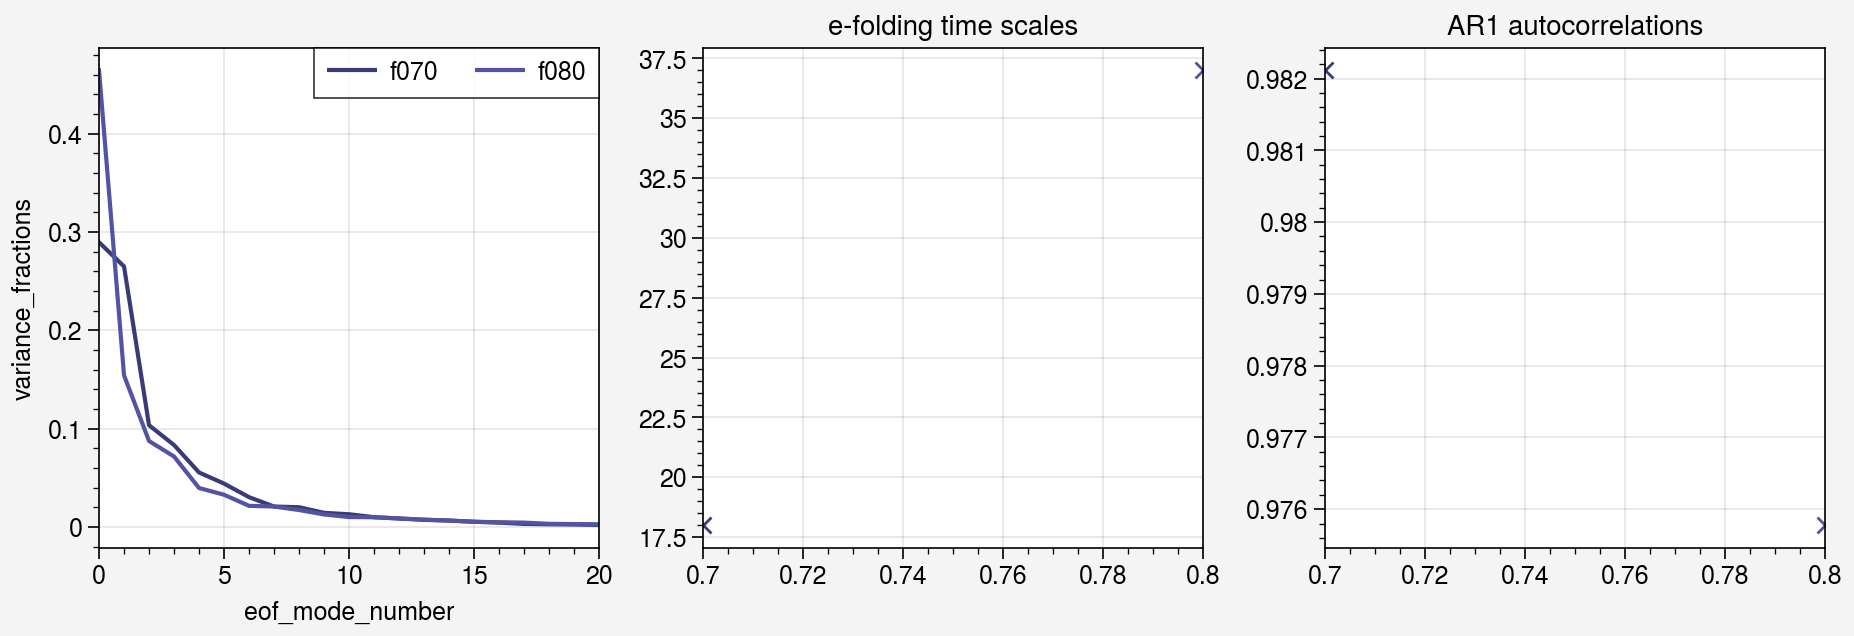

In [11]:
fig, ax = pplt.subplots(ncols=3, cycle='tab20b', share=False)

n_eff = np.zeros(len(exp_names))
lag_range = range(1, 40)

for j, exp_name in enumerate(exp_names):
    ds = ds_eofs.sel(mode=slice(0,20), exp_name=exp_name)
    pc = ds_pcs.pcs.sel(mode=0, exp_name=exp_name)
    dt = 1 # days 
    
    fg = get_fgamma_from(exp_name)
    ax[0].plot(ds.mode, ds.var_exp, label=f'{exp_name[-4:]}')

    r_lag = [np.abs(np.corrcoef(pc.values[i:], pc.values[:-i])[1,0]) for i in lag_range]
    r_a1pc = r_lag[0]
    
    #t_efold = - dt/np.log(r_a1pc)
    t_efold = np.where(np.array(r_lag) - 1/np.e <= 0)[0]
    if t_efold.size == 0:
        t_efold = np.nan
    elif t_efold.size > 1:
        t_efold = t_efold[0]
    
    ax[1].plot(fg, t_efold, 'x')
    ax[2].plot(fg,  r_a1pc, 'x')    
    #print(f'autocorrelation PC {1}: {r_a1pc} \n e-folding time: {- dt/np.log(r_a1pc):.3} days')
    n_eff[j] = pc.time.size * (1 - r_a1pc)/(1 + r_a1pc)

ax[0].legend()
ax[1].set_title('e-folding time scales')
ax[2].set_title('AR1 autocorrelations')

for i in range(len(exp_names)):
    print(f'{exp_names[i]}\'s effective sample size: {n_eff[i]}')
    
fig.savefig(f'Intercomparison_eofs_var_exp_time_scales.{plot_format}')

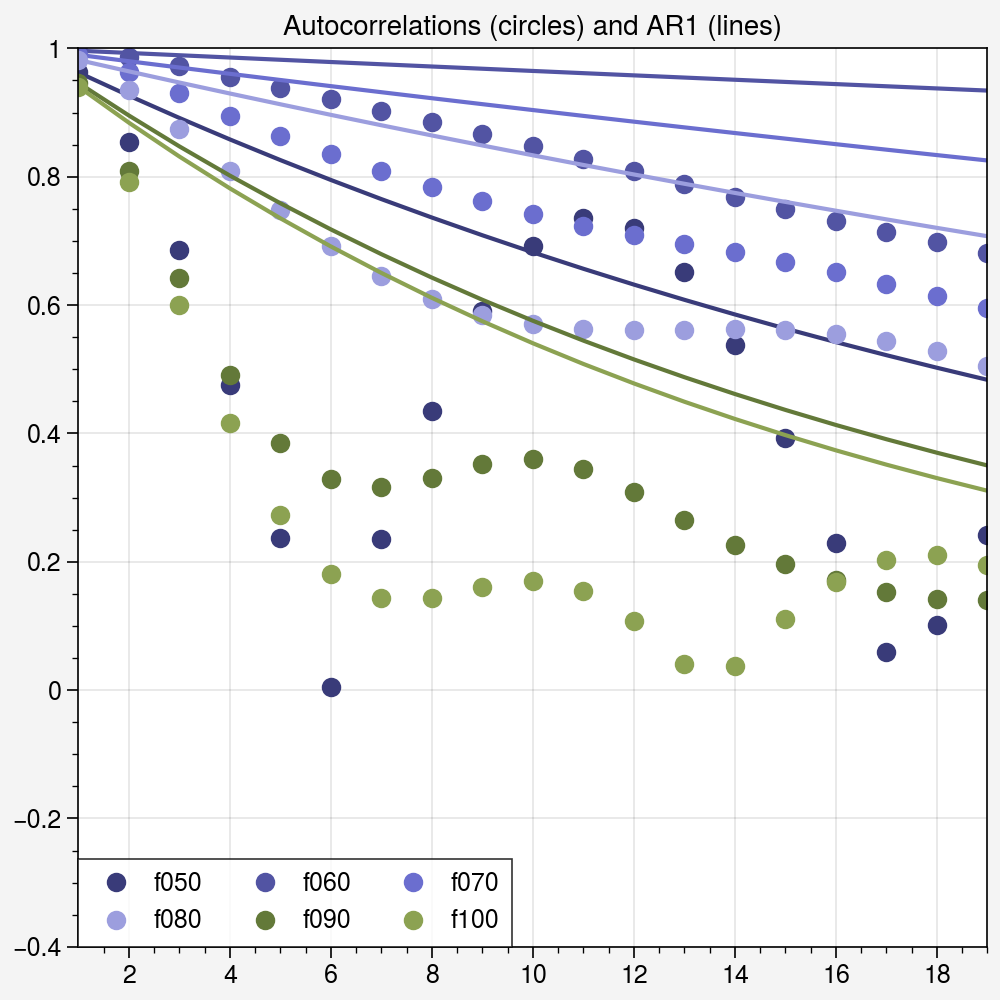

In [13]:
fig, ax  = pplt.subplots(figsize=(5,5), cycle='tab20b')
lag_range = range(1, 20)

for exp_name in exp_names:
    pc = ds_pcs.pcs.sel(mode=0, exp_name=exp_name)
    r_lag = [np.abs(np.corrcoef(pc.values[i:], pc.values[:-i])[1,0]) for i in lag_range]
    r_lag_alt = [0.5 * np.abs(np.corrcoef(pc.values[i:], pc.values[:-i])[1,0]) + 0.5 * np.abs(np.corrcoef(pc.values[i+1:], pc.values[:-(i+1)])[1,0]) ** 0.5 for i in lag_range]
    fg = get_fgamma_from(exp_name)

    color=next(ax[0]._get_lines.prop_cycler)['color']
    ax.plot(lag_range, r_lag, 'o', label=f'{exp_name[-4:]}', color=color)
    ax.plot(lag_range, r_lag[0] ** lag_range, color=color)


ax.set_ylim([-0.4, 1])
ax.legend()
ax.set_title('Autocorrelations (circles) and AR1 (lines)')

fig.savefig(f'Intercomparison_eofs_autocorr.{plot_format}')

In [4]:
def plot_t_profiles_intercomp(ds, fig=None, ax=None, linestyle='-', fgammas=[], l_tropics=[0,20], l_midlat=[50,70]):
    
    ds = calc_avg_btw_hemispheres(ds.mean('time'))
    z = ds.geopot_p.mean(['lat'])/9.81
    z = z.sel(plev=slice(10,1000))
    
    if fig is None:
        fig, ax = pplt.subplots(nrows = 1, ncols = 2, figsize = (8, 5), figtitle='Average Temperature Profiles')

    en = str(ds.exp_name.values)
    fg = get_fgamma_from(en)

    titles = [f'T-profiles between {l_tropics[0]}° & {l_tropics[1]}°', f'T-profiles between {l_midlat[0]}° & {l_midlat[1]}°']

    ax[0].plot(ds.tm1.sel(lat=slice(l_tropics[0],l_tropics[1])).mean('lat'), ds.plev, label=r'$f_{\gamma} = $'+str(fg), cycle = 'tab10', linestyle=linestyle)    
    ax[0].set_xlim([305,175])
    ax[1].plot(ds.tm1.sel(lat=slice(l_midlat[0],l_midlat[1])).mean('lat'), ds.plev, label=r'$f_{\gamma} = $'+str(fg), cycle = 'tab10', linestyle=linestyle)
    ax[1].set_xlim([275, 195])

    for i,a in enumerate(ax):
        
        for f in fgammas:
            a.plot((ds_sel.tm1.dropna('plev').isel(plev=-1).values - f * 0.0098 * z), ds.plev) #, label=f'$f_{{\gamma}} = {f:.1f}$', color='gray')
        
        a.set_title(titles[i])
        a.legend(fontsize='x-small', loc='upper left')
        a.set_ylim([1000,10])
        a.set_yscale('log')

    return fig, ax
    

In [5]:
def plot_t_contours_intercomp(ds, exp_names, fig=None, ax=None, l_tropics=[0,20], l_midlat=[50,70]):
    
    ds = calc_avg_btw_hemispheres(ds.mean('time'))
    z = ds.geopot_p.mean(['lat'])/g0 / 1000 # [km]

    if fig is None:
        fig, ax = pplt.subplots(nrows = 1, ncols = 2, figsize = (8, 5), figtitle='Average Temperature Profiles')

    fgs = np.array([get_fgamma_from(en) for en in exp_names])

    titles = [f'T-profiles between {l_tropics[0]}° & {l_tropics[1]}°', f'T-profiles between {l_midlat[0]}° & {l_midlat[1]}°']

    ax[0].pcolormesh(fgs, z.mean('exp_name'), ds.tm1.sel(lat=slice(l_tropics[0],l_tropics[1])).mean('lat').T, colorbar='right')
    ax[1].pcolormesh(fgs, z.mean('exp_name'), ds.tm1.sel(lat=slice(l_midlat[0],l_midlat[1])).mean('lat').T, colorbar='right')

    #ax[0].plot(ds.tm1.sel(lat=slice(l_tropics[0],l_tropics[1])).mean('lat'), ds.plev, label=r'$f_{\gamma} = $'+str(fg), cycle = 'tab10', linestyle=linestyle)    
    #ax[1].plot(ds.tm1.sel(lat=slice(l_midlat[0],l_midlat[1])).mean('lat'), ds.plev, label=r'$f_{\gamma} = $'+str(fg), cycle = 'tab10', linestyle=linestyle)

    for i,a in enumerate(ax):
        a.set_title(titles[i])
        a.set_ylim([0,25])
        a.set_xlabel(r'$f_{\gamma}$')
        a.set_ylabel('geopotential height [km]')

    return fig, ax

def plot_dtdz_contours_intercomp(ds, exp_names, fig=None, ax=None, l_tropics=[0,20], l_midlat=[50,70]):
    
    ds = calc_avg_btw_hemispheres(ds.mean('time'))
    z = ds.geopot_p.mean(['lat'])/g0 / 1000 # [km]
    dtdz = calc_da_derivative(ds.tm1, z, coord_name='plev')
    dtdz_levels = np.arange(-10,10.1,1)
    
    if fig is None:
        fig, ax = pplt.subplots(nrows = 1, ncols = 2, figsize = (8, 5), figtitle=r'Average $dT/dz$ Profiles')

    fgs = np.array([get_fgamma_from(en) for en in exp_names])

    titles = [f'profiles between {l_tropics[0]}° & {l_tropics[1]}°', f'profiles between {l_midlat[0]}° & {l_midlat[1]}°']

    ax[0].pcolormesh(fgs, z.mean('exp_name'), dtdz.sel(lat=slice(l_tropics[0],l_tropics[1])).mean('lat').T, colorbar='right', levels=dtdz_levels)
    ax[1].pcolormesh(fgs, z.mean('exp_name'), dtdz.sel(lat=slice(l_midlat[0],l_midlat[1])).mean('lat').T, colorbar='right', levels=dtdz_levels)

    for i,a in enumerate(ax):
        a.set_title(titles[i])
        a.set_xlabel(r'$f_{\gamma}$')
        a.set_ylabel('geopotential height [km]')
        a.set_ylim([0,25])

    return fig, ax
    

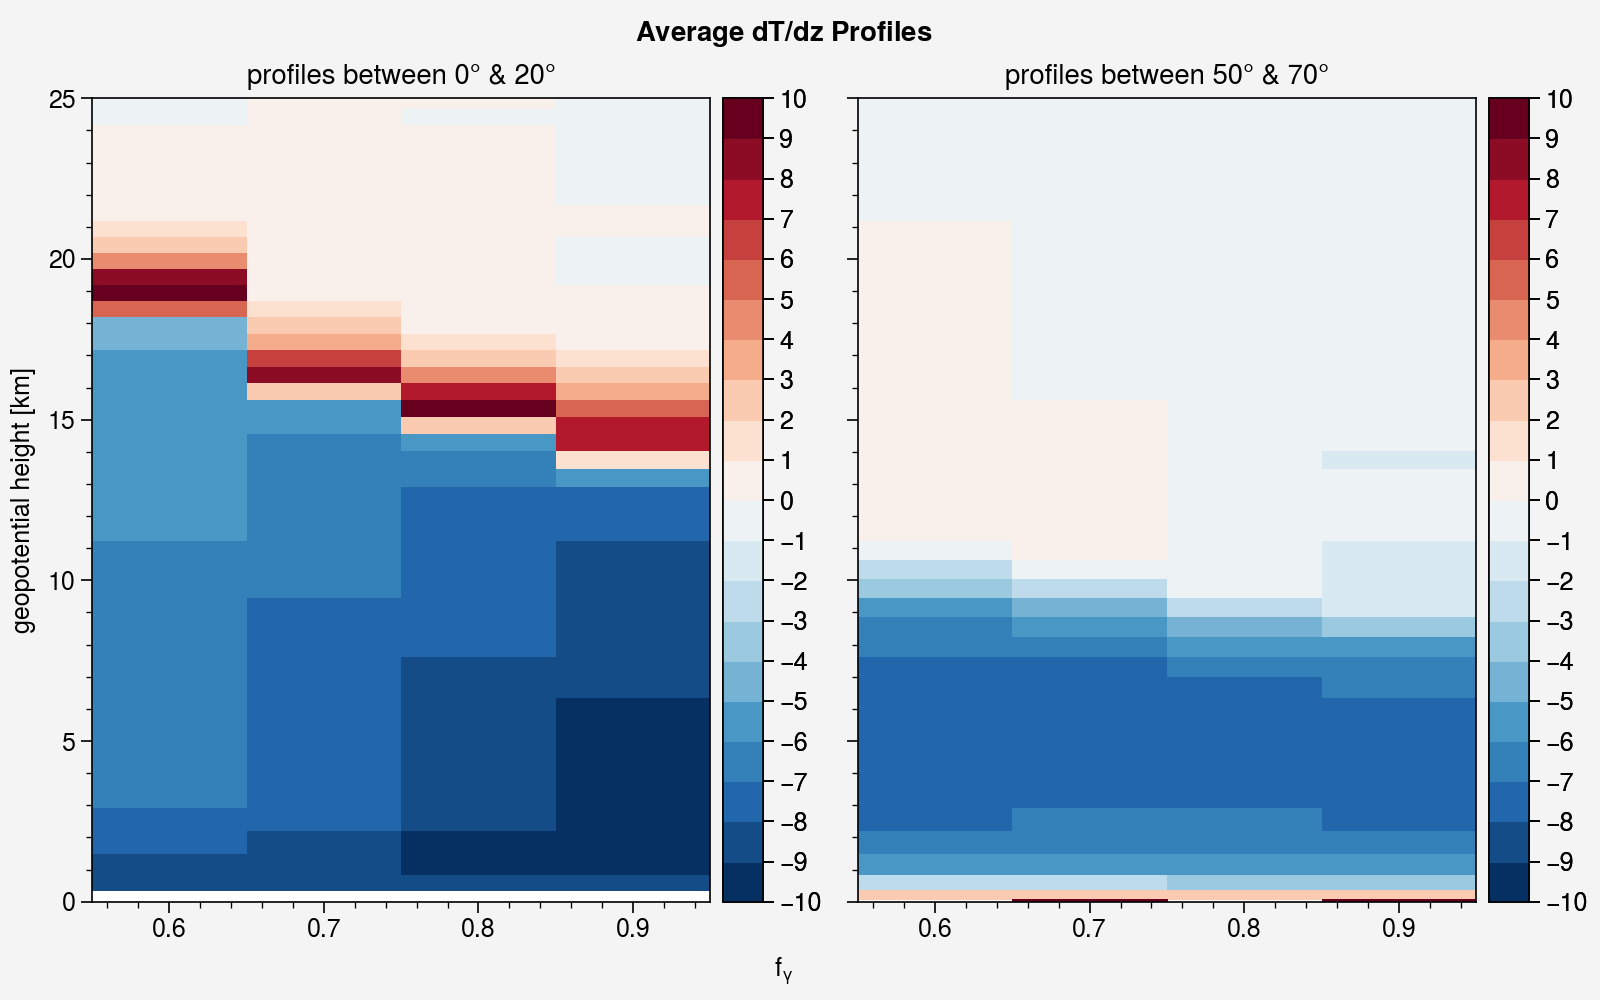

In [6]:
fig, ax = plot_dtdz_contours_intercomp(ds_zm, exp_names)
fig.savefig(f'Intercomparison_dtdz.{plot_format}')

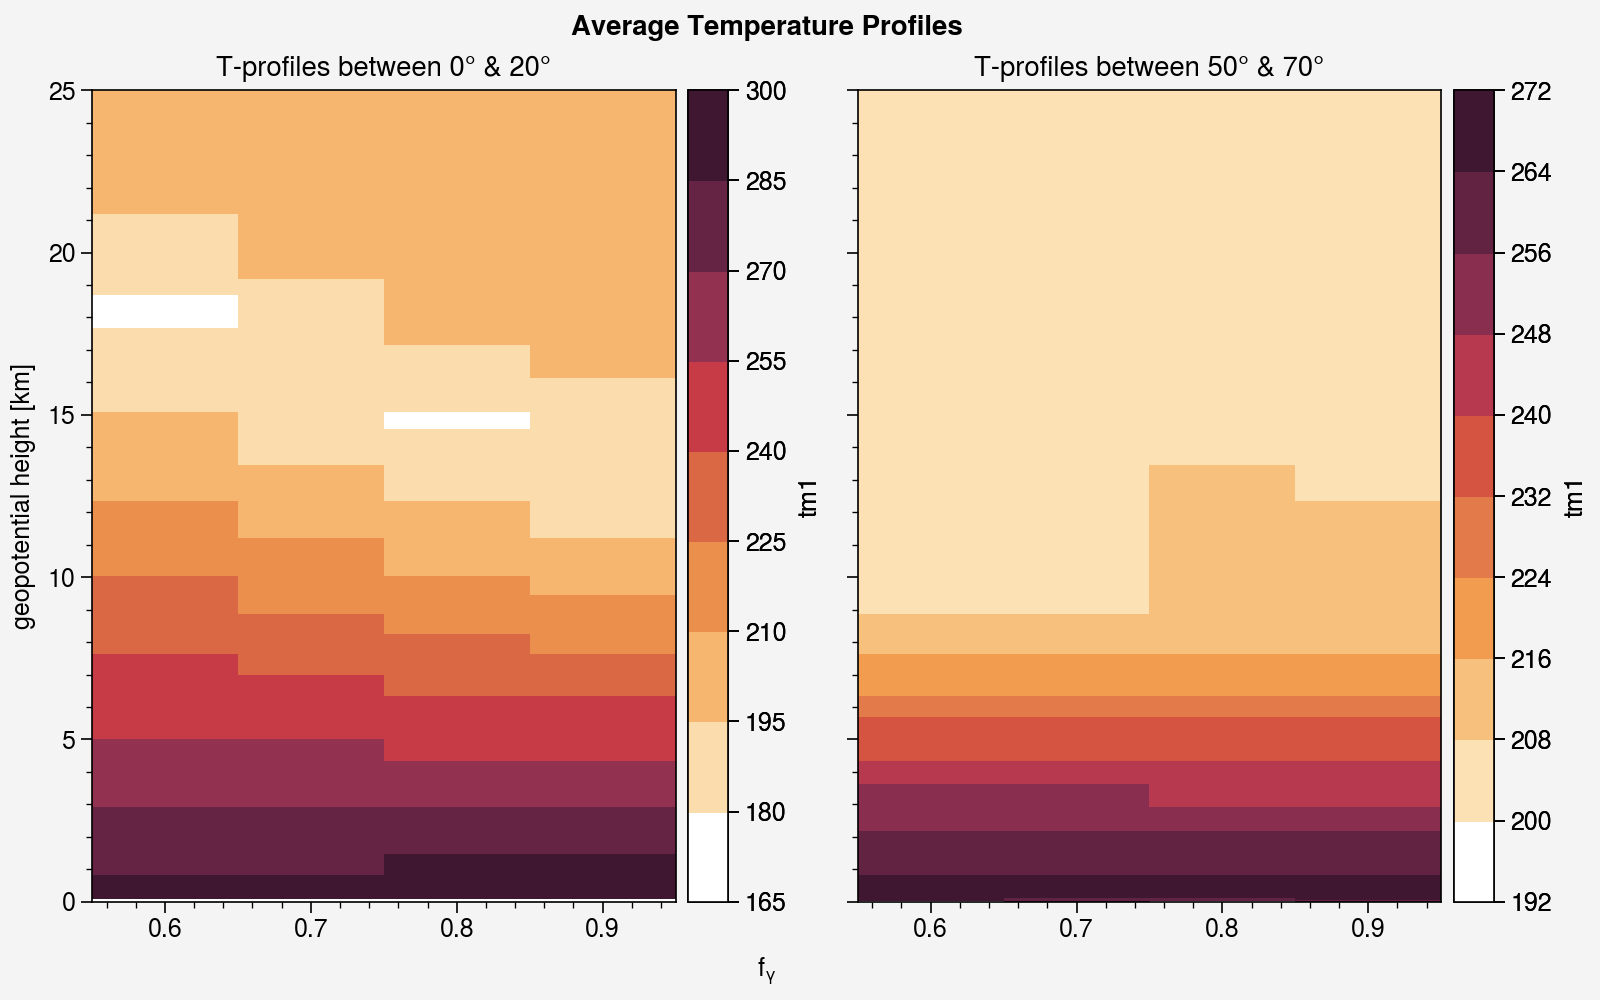

In [7]:
fig, ax = plot_t_contours_intercomp(ds_zm, exp_names)
fig.savefig(f'Intercomparison_t_contours.{plot_format}')

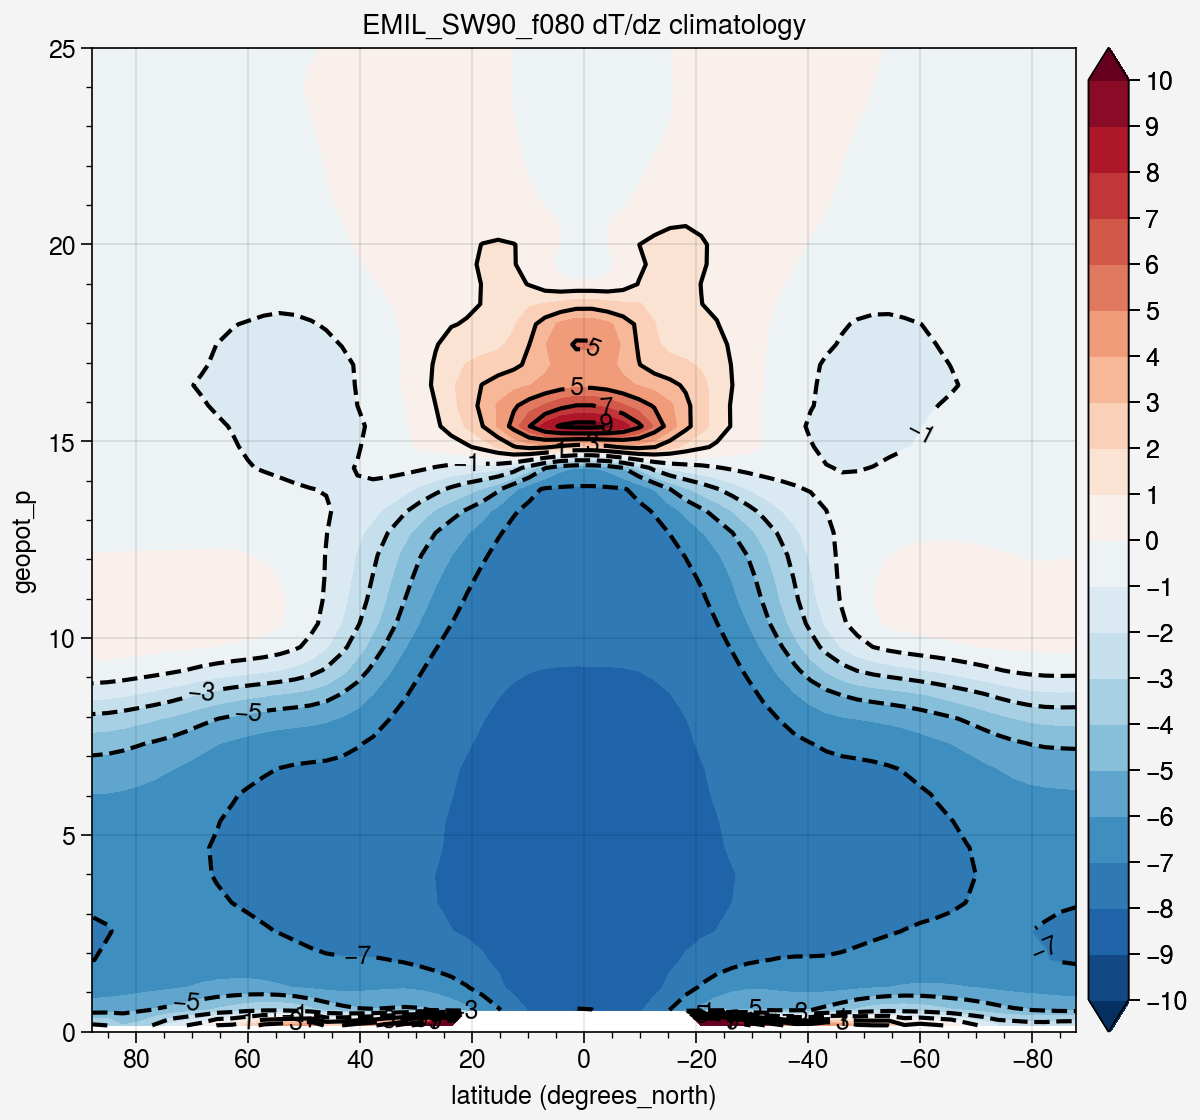

In [58]:
def plot_dtdz_clim(ds):

    fig, ax = pplt.subplots(figwidth=6)

    z = ds.geopot_p.mean(['lat'])/g0 / 1000 # [km]
    dtdz = calc_da_derivative(ds.tm1, z, coord_name='plev')
    dtdz_levels = np.arange(-10,10.1,1)

    z[89] = 0

    ax.contourf(ds.lat, z, dtdz.T, colorbar='right', levels=dtdz_levels, extend='both')
    ax.contour(ds.lat, z, dtdz.T, levels=dtdz_levels[1::2], color='black', labels=True)
    ax.set_ylim([0,25])
    
    return fig, ax

en = 'EMIL_SW90_f080'
fig, ax = plot_dtdz_clim(ds_zm.sel(exp_name=en).mean('time'))

ax.set_title(f'{en} dT/dz climatology')
fig.savefig(f'{en}_dtdz_climatology.{plot_format}')

In [ ]:
for en in exp_names:
    fig, ax = plot_dtdz_clim(ds_zm.sel(exp_name=en).mean('time'))

    ax.set_title(f'{en} dT/dz climatology')
    fig.savefig(f'{en}_dtdz_climatology.{plot_format}')
    

In [ ]:
fig, ax = pplt.subplots(nrows = 1, ncols = 2, figsize = (8, 5), figtitle='Average Temperature Profiles')

ds = ds_zm

for i,en in enumerate(exp_names):
    fig, ax = plot_t_profiles_intercomp(ds.sel(exp_name=en), fig=fig, ax=ax, linestyle=linestyles[int(i/10)])
    
fig.show()

### Scatterplots

In [ ]:
ds_diagn

<xarray.Dataset>
Dimensions:       (exp_name: 26, hemisphere: 2)
Coordinates:
  * exp_name      (exp_name) object 'EMIL_SW120f050' ... 'EMIL_SW90_f100'
  * hemisphere    (hemisphere) object 'NH' 'SH'
Data variables: (12/20)
    Ty_actual     (exp_name, hemisphere) float64 46.28 47.67 ... 39.74 39.91
    Ty_eff        (exp_name, hemisphere) float64 46.7 53.7 56.05 ... 90.23 90.23
    Ty_equ        (exp_name, hemisphere) object 50 50 60 60 70 ... 90 90 90 90
    edj_lat       (exp_name, hemisphere) float64 52.32 51.86 ... 28.84 28.84
    edj_max       (exp_name, hemisphere) float64 9.355 9.577 ... 7.644 8.045
    lat_0         (exp_name, hemisphere) object 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0
    ...            ...
    f_gamma       (exp_name, hemisphere) float64 0.5 0.5 0.6 0.6 ... 0.9 1.0 1.0
    T_coldpoint   (exp_name, hemisphere) float64 183.9 183.9 ... 182.8 182.8
    Psi_max       (exp_name, hemisphere) float64 4.369e+10 ... -3.108e+11
    Psi_0         (exp_name, hemisphere) float64 32.85 32.45 ... 18.95 18.98
    edj_ep_bdgt   (exp_name, hemisphere) float64 nan nan nan ... -13.8 -14.83
    jet_sep       (exp_name, hemisphere) float64 17.44 16.98 ... 2.325 3.256

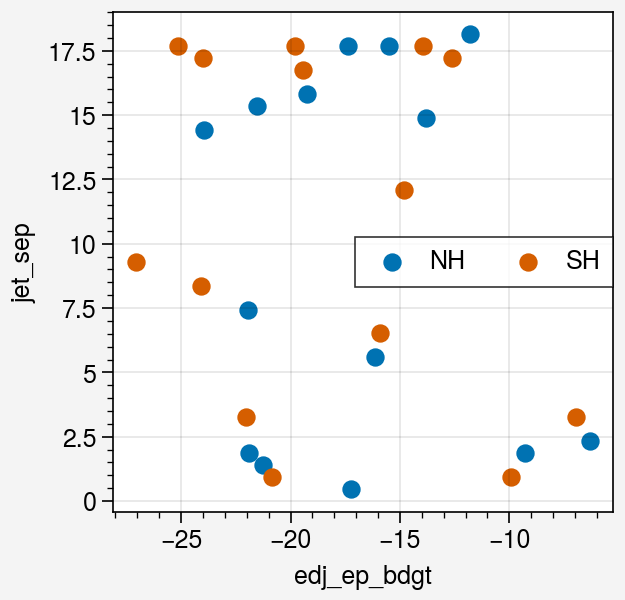

In [39]:
met1 = 'edj_ep_bdgt'
met2 = 'jet_sep'

ds = ds_diagn.sel(exp_name=exp_names)

fig, ax = pplt.subplots()

ax.scatter(ds[met1], ds[met2])
ax.legend()

fig.savefig(f'Intercomparison_scatterplot_{met1}_{met2}.{plot_format}')

In [ ]:
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe().reset_index(), vars=['Ty_actual', 'edj_lat', 'edj_max'], hue='hemisphere', diag_kind='hist')
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe(), vars=['Ty_actual', 'edj_lat', 'edj_max'])
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe(), vars=['Ty_actual', 'stj_lat', 'stj_max', 'stj_plev'])
#sns.pairplot(ds_diagn.sel(exp_name=exp_names).to_dataframe())

ds = ds_diagn.sel(exp_name=exp_names)
metrics = list(ds_diagn.keys())
comp_metric = 'f_gamma'

fig, axes = pplt.subplots(nrows=len(metrics), share=False)

for i,met in enumerate(metrics):
    
    axes[i].scatter(ds[met], ds[comp_metric])
    
for ax in axes:
    ax.legend()
    
fig.savefig(f'Intercomparison_scatterplots.{plot_format}')

In [9]:
plt.show()

### Momentum Transports

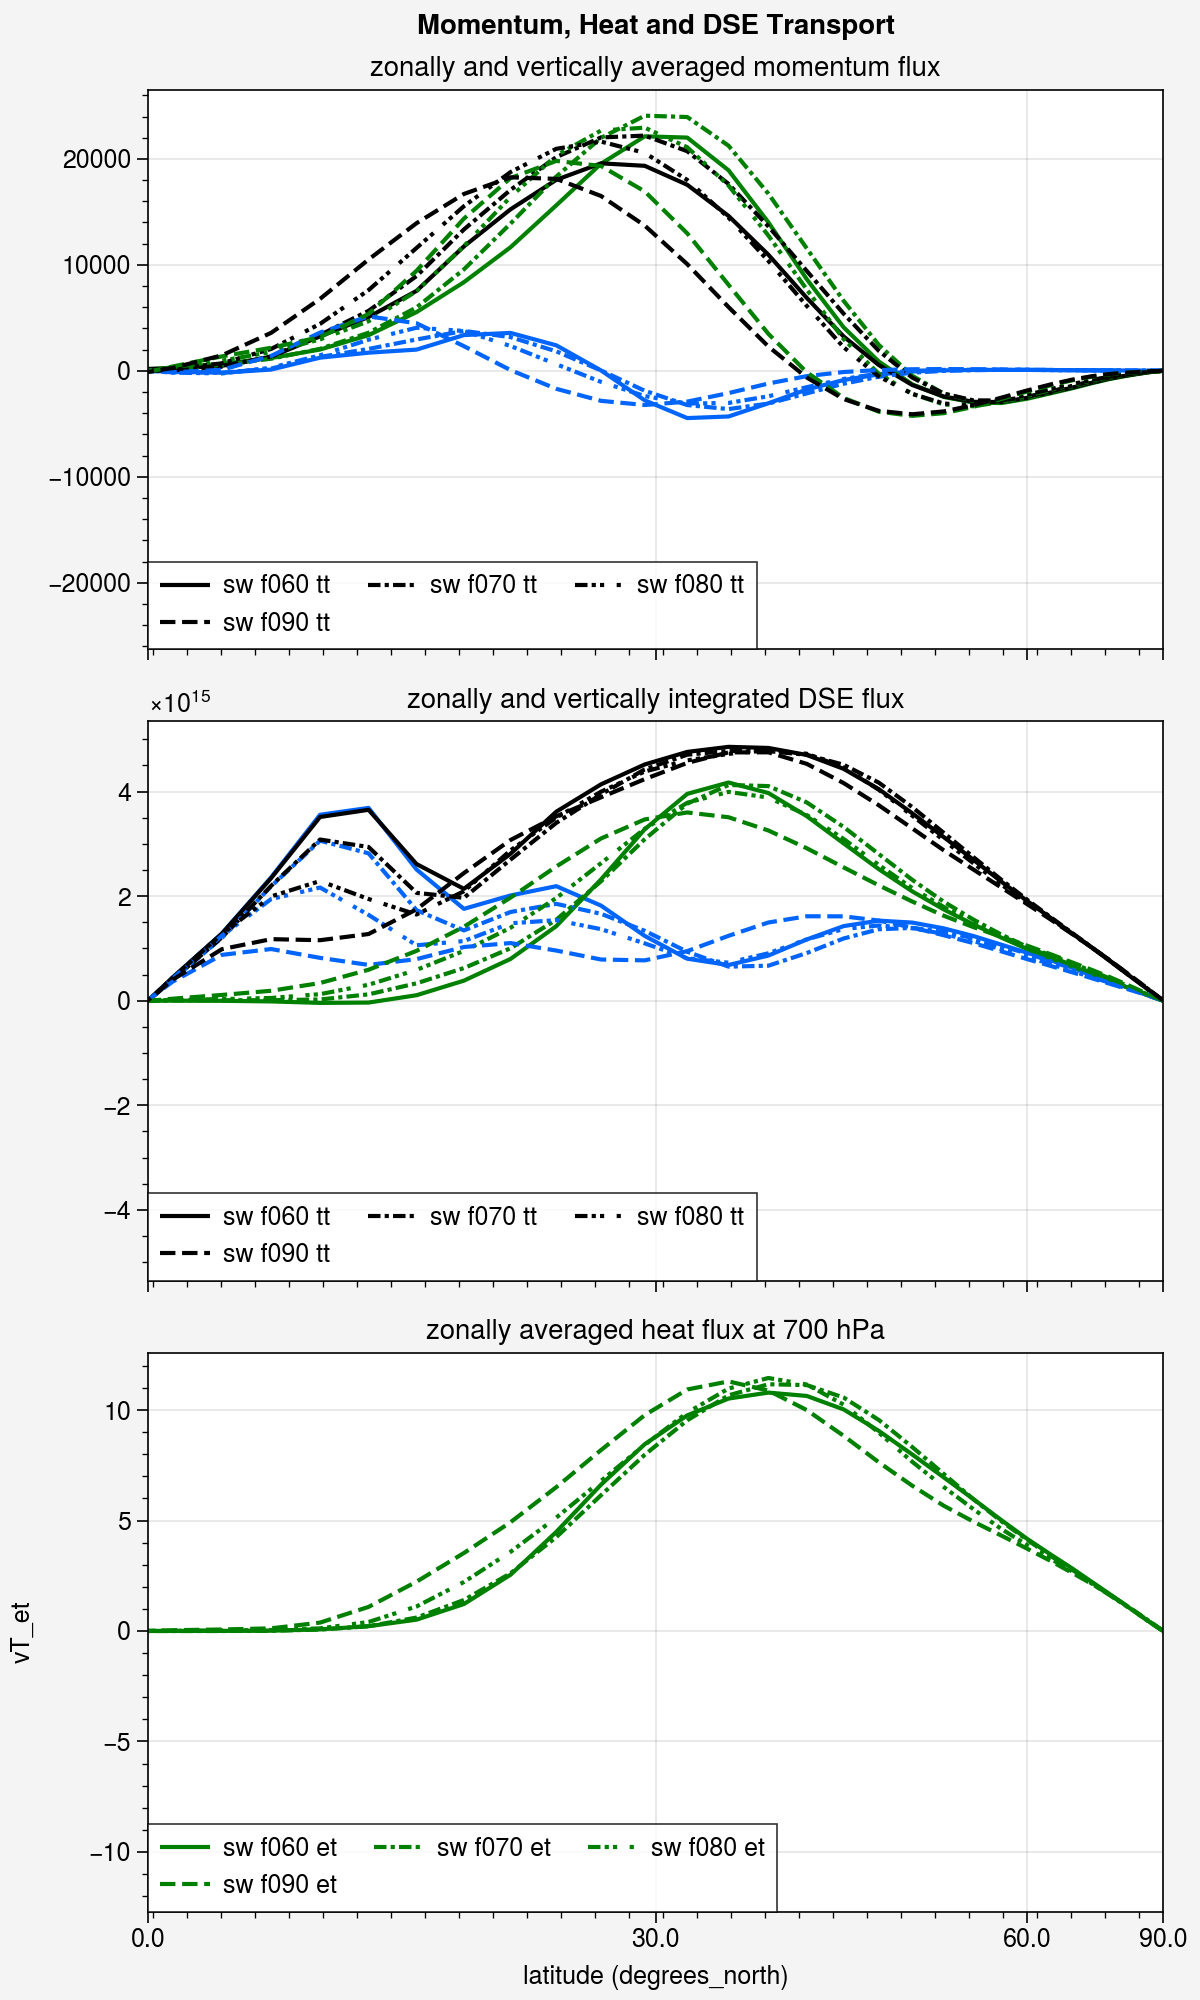

In [8]:
fig, ax = pplt.subplots(nrows = 3, ncols = 1, figsize = (6, 10), figtitle='Momentum, Heat and DSE Transport')

ds = ds_tp#calc_avg_btw_hemispheres(ds_tp)

for i,en in enumerate(exp_names):
    fig, ax = plot_transports_intercomp(ds.sel(exp_name=en), vert_weights, 
                                        fig=fig, ax=ax, linestyle=linestyles[i],
                                       )

for a in ax:
    a.set_xlim([0,1])
fig.show()
fig.savefig(f'Intercomparison_fluxes.{plot_format}')

### Jets

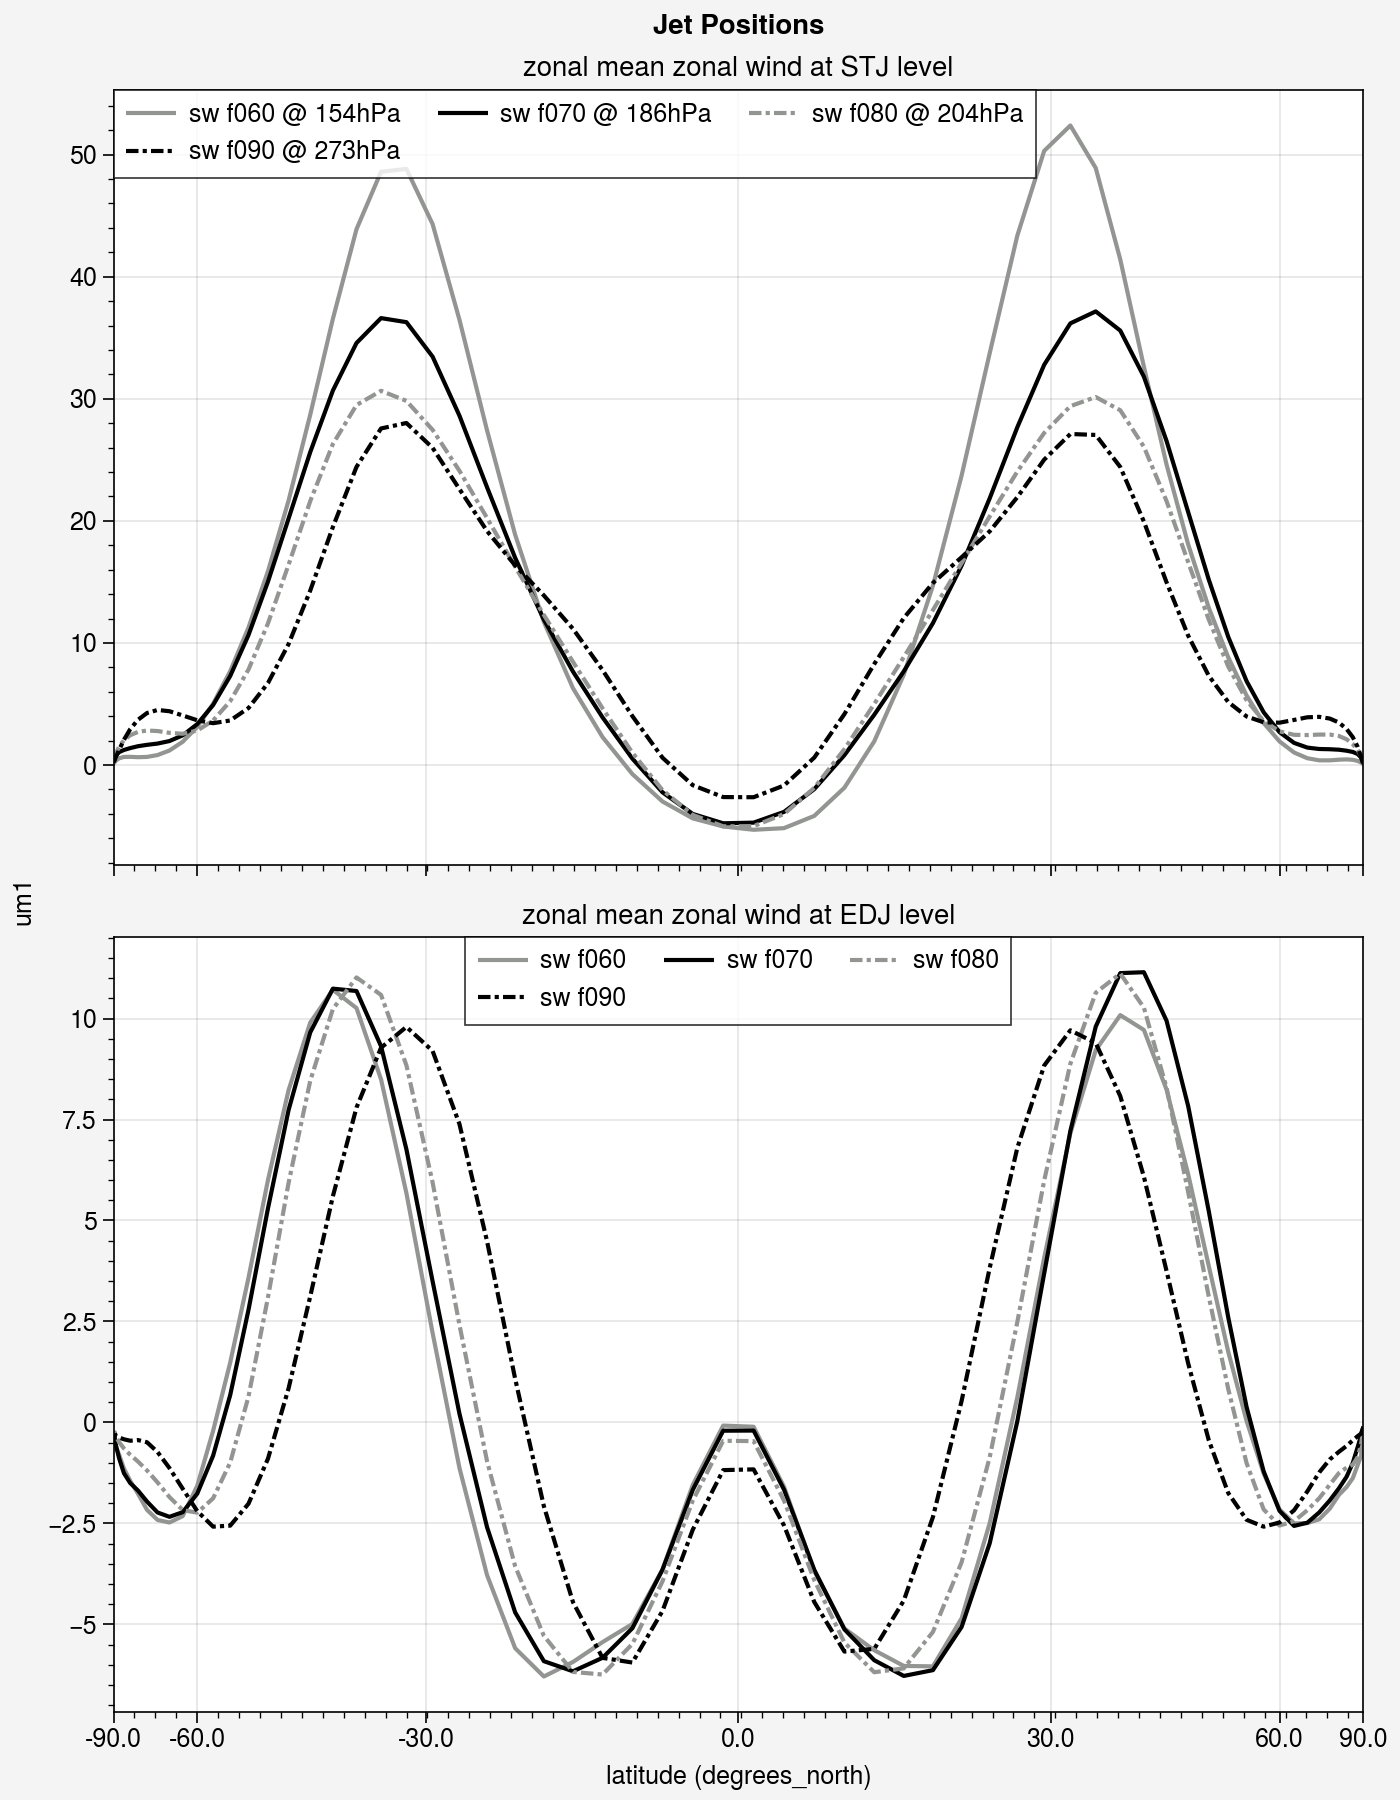

In [9]:
fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Jet Positions')

ds = ds_zm

for i,en in enumerate(exp_names):
    fig, ax = plot_u_jets_intercomp(ds.um1.T.sel(exp_name=en), 
                                        fig=fig, ax=ax, linestyle=linestyles[int(i/2)], color=alternation_colors[i%2]
                                       )
    

fig.show()
fig.savefig(f'Intercomparison_jets.{plot_format}')

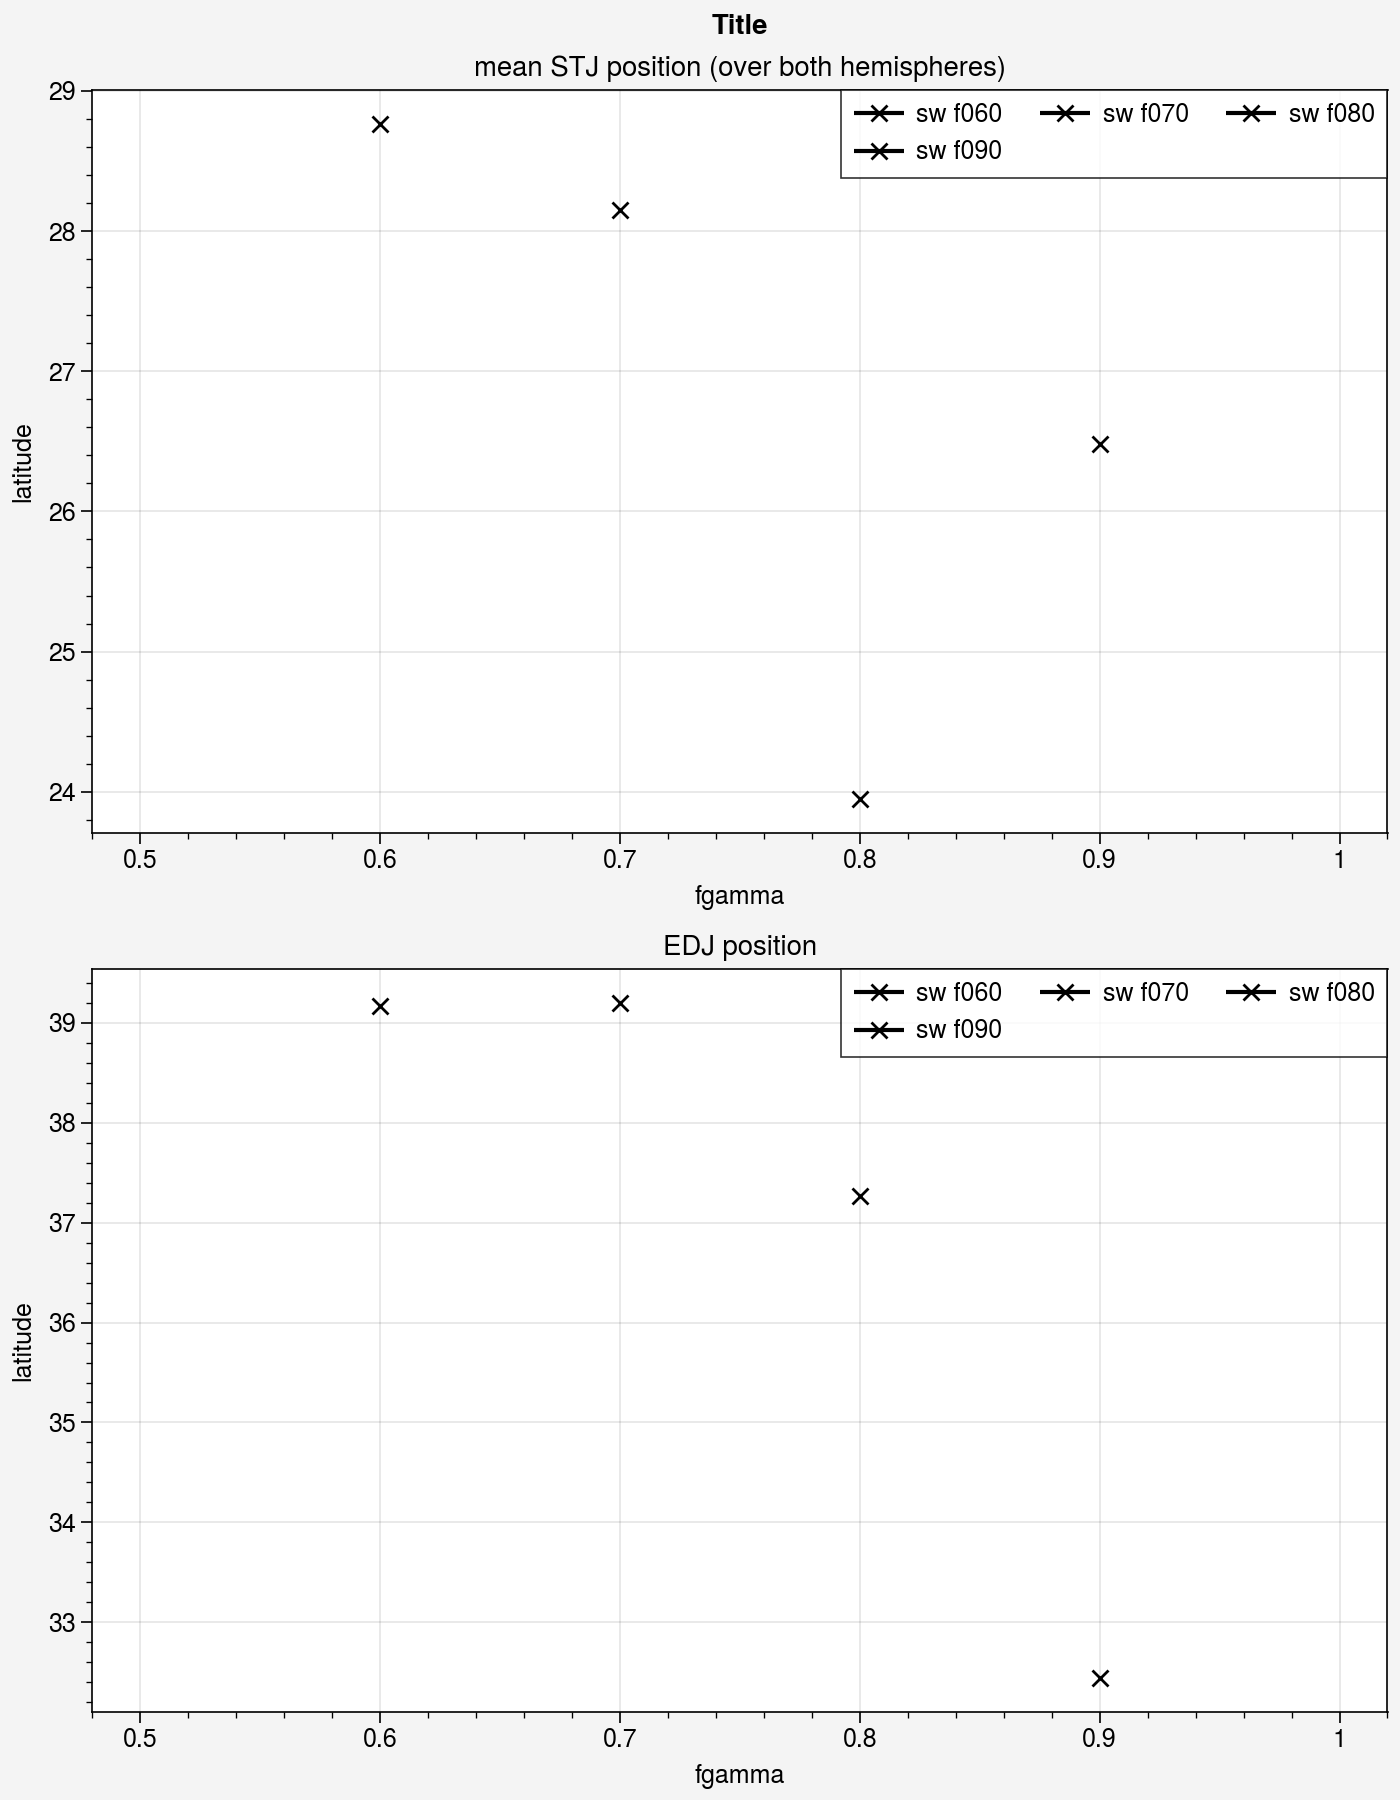

In [10]:
fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Title', share=False)

colors = ['black', 'bright green', 'bright blue', 'purple', 'orange']

for i,en in enumerate(exp_names):
    fig, ax = plot_jet_metrics(ds_zm.um1.T.sel(exp_name=en), 
                                        fig=fig, ax=ax, color=colors[0],
                                       )

#ax[0].legend(loc='upper left')
#ax[1].legend()
    
for a in ax:
    a.set_xlim([0.48, 1.02])

fig.show()
fig.savefig(f'Intercomparison_jet_lats_metric.{plot_format}')

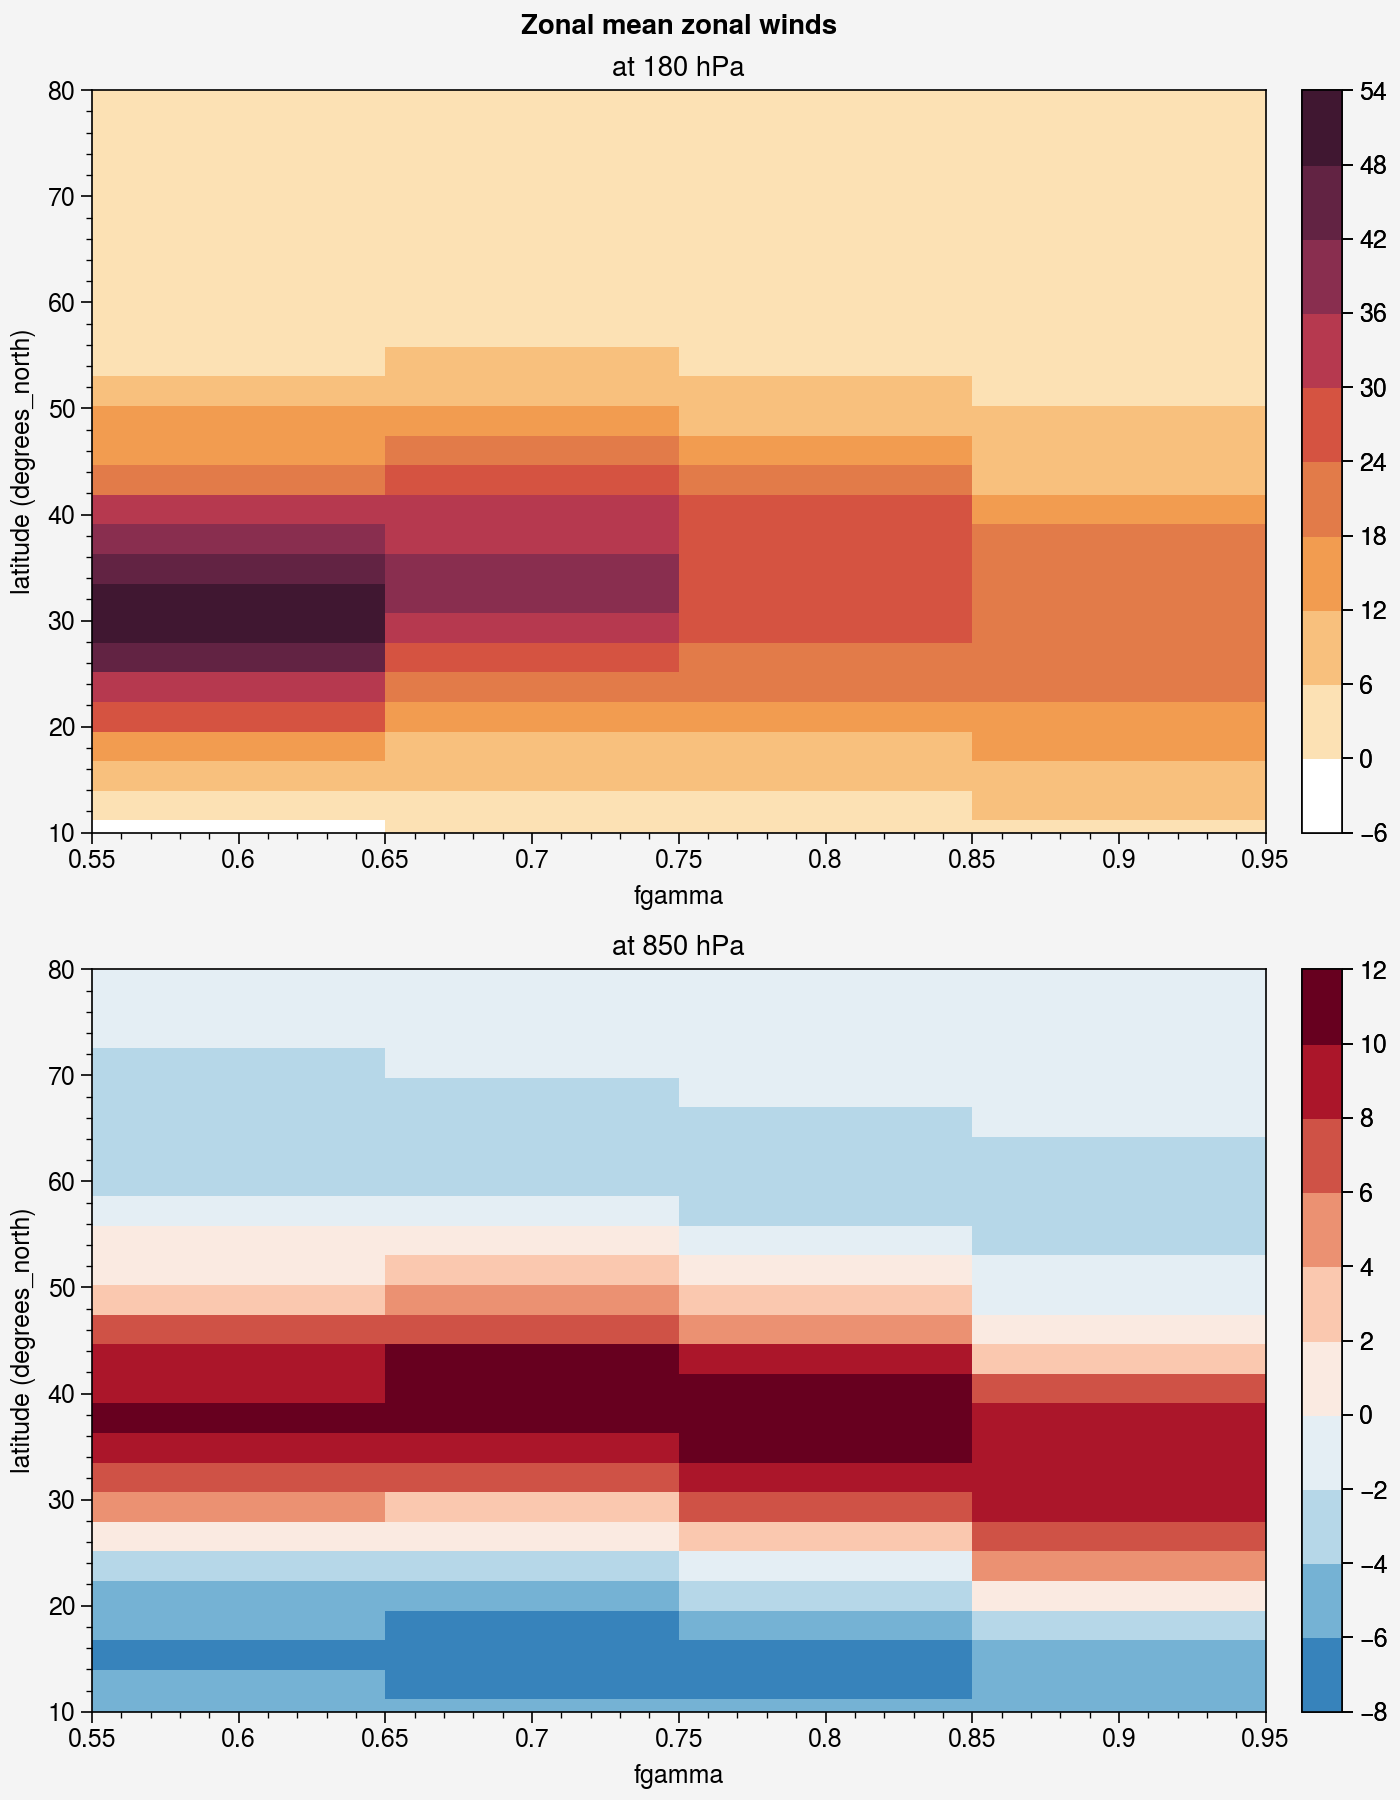

In [11]:
fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Zonal mean zonal winds', share=False)

fig, ax = plot_jet_contours_intercomp(ds_zm, exp_names, fig=fig, ax=ax)

fig.savefig(f'Intercomparison_jet_colormesh.{plot_format}')

### EKE

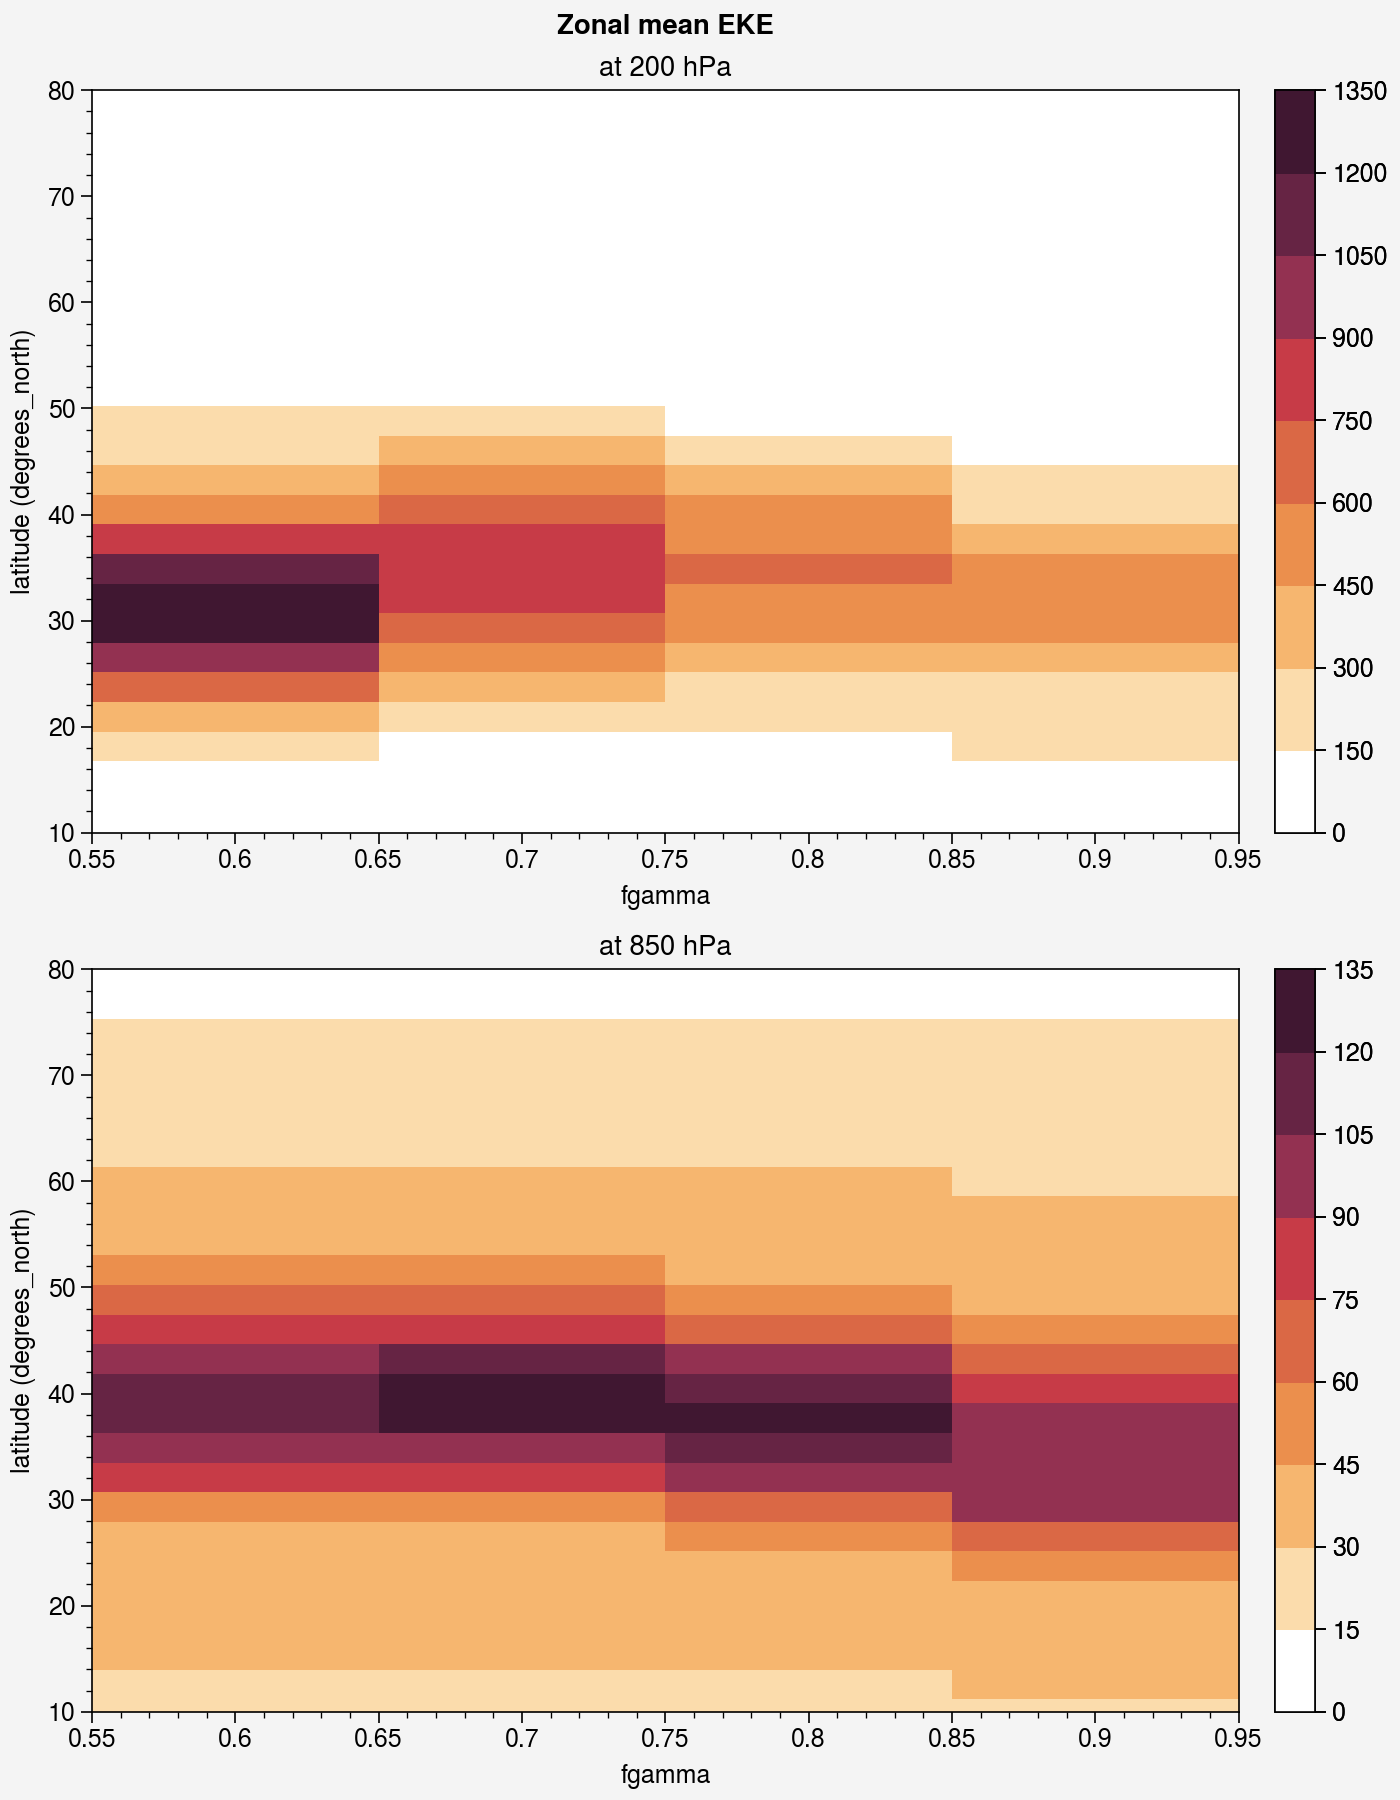

In [12]:
fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Zonal mean EKE', share=False)

fig, ax = plot_eke_contours_intercomp(ds_zm, exp_names, fig=fig, ax=ax)

fig.savefig(f'Intercomparison_eke_colormesh.{plot_format}')

### Streamfunction

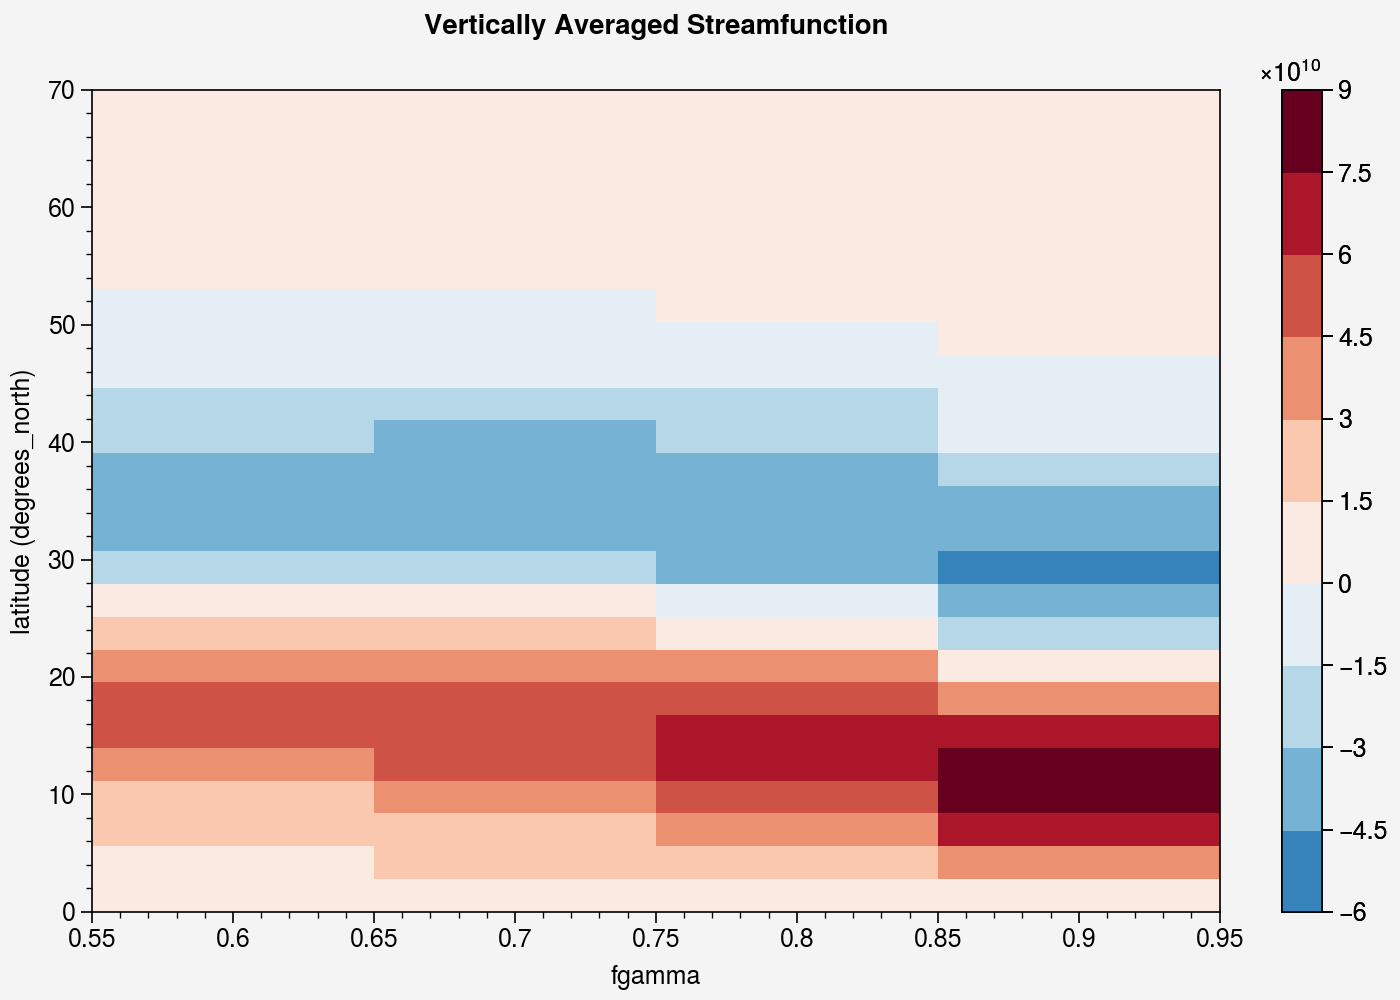

In [13]:
fig, ax = pplt.subplots(nrows = 1, ncols = 1, figsize = (7, 5), figtitle='Vertically Averaged Streamfunction')

fig, ax = plot_psi_contours_intercomp(ds_zm, exp_names, vert_weights, fig=fig, ax=ax)

fig.savefig(f'Intercomparison_psi_colormesh.{plot_format}')

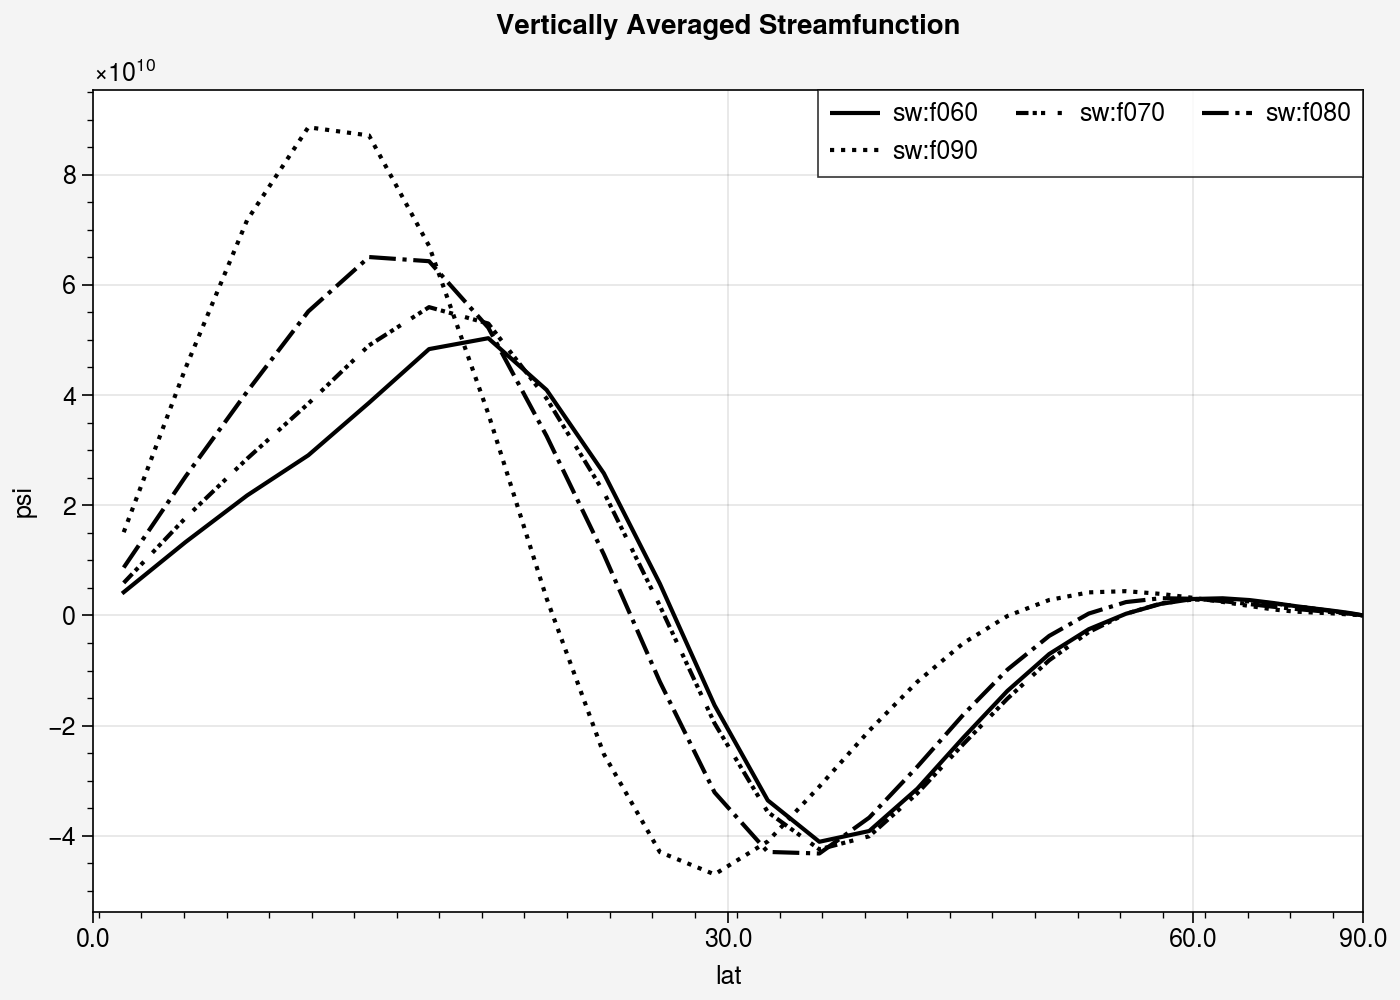

In [22]:
fig, ax = pplt.subplots(nrows = 1, ncols = 1, figsize = (7, 5), figtitle='Vertically Averaged Streamfunction')

ds = ds_hem_avg

for i,en in enumerate(exp_names):
    fig, ax = plot_psi_intercomp(ds.sel(exp_name=en).mean('time'), vert_weights,
                                 fig=fig, ax=ax, linestyle=linestyles[int(i*2)], color='black') # alternation_colors[i%2]

ax.set_xlim([0,1])
fig.show()
fig.savefig(f'Intercomparison_streamfunction.{plot_format}')

### Tropopause

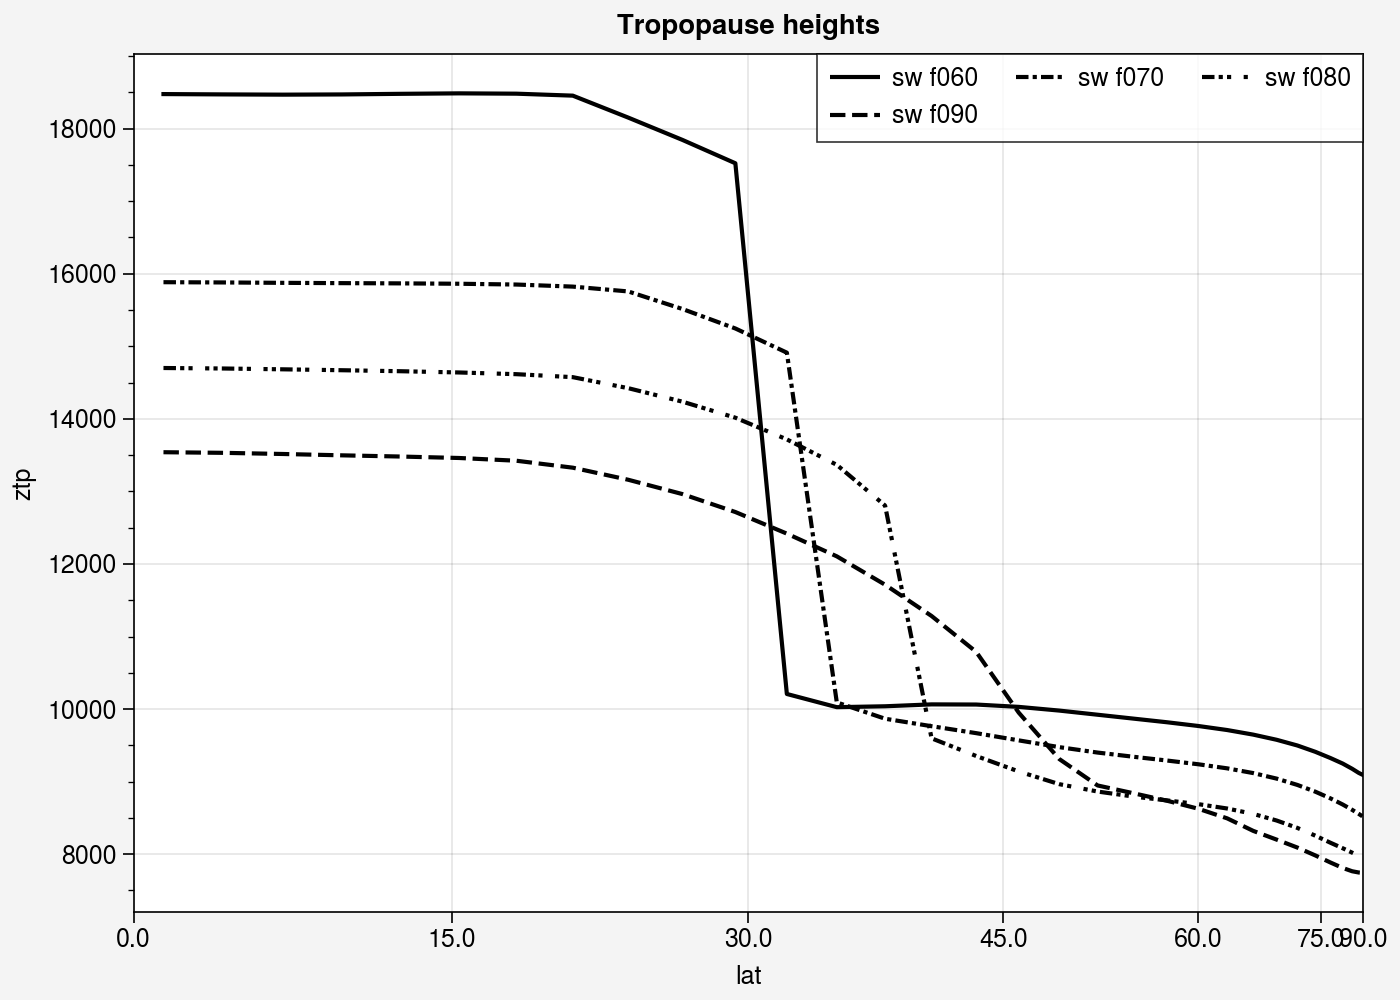

In [19]:
fig, ax = pplt.subplots(nrows = 1, ncols = 1, figsize = (7,5), figtitle='Tropopause heights')

ds = ds_hem_avg

for i,en in enumerate(exp_names):
    fig, ax = plot_lines_tp_height_intercomp(ds.sel(exp_name=en), fig=fig, ax=ax,
                                             linestyle=linestyles[i],
                                       )
ax.set_xlim([0,1])
fig.show()
fig.savefig(f'Intercomparison_ztp_lines.{plot_format}')

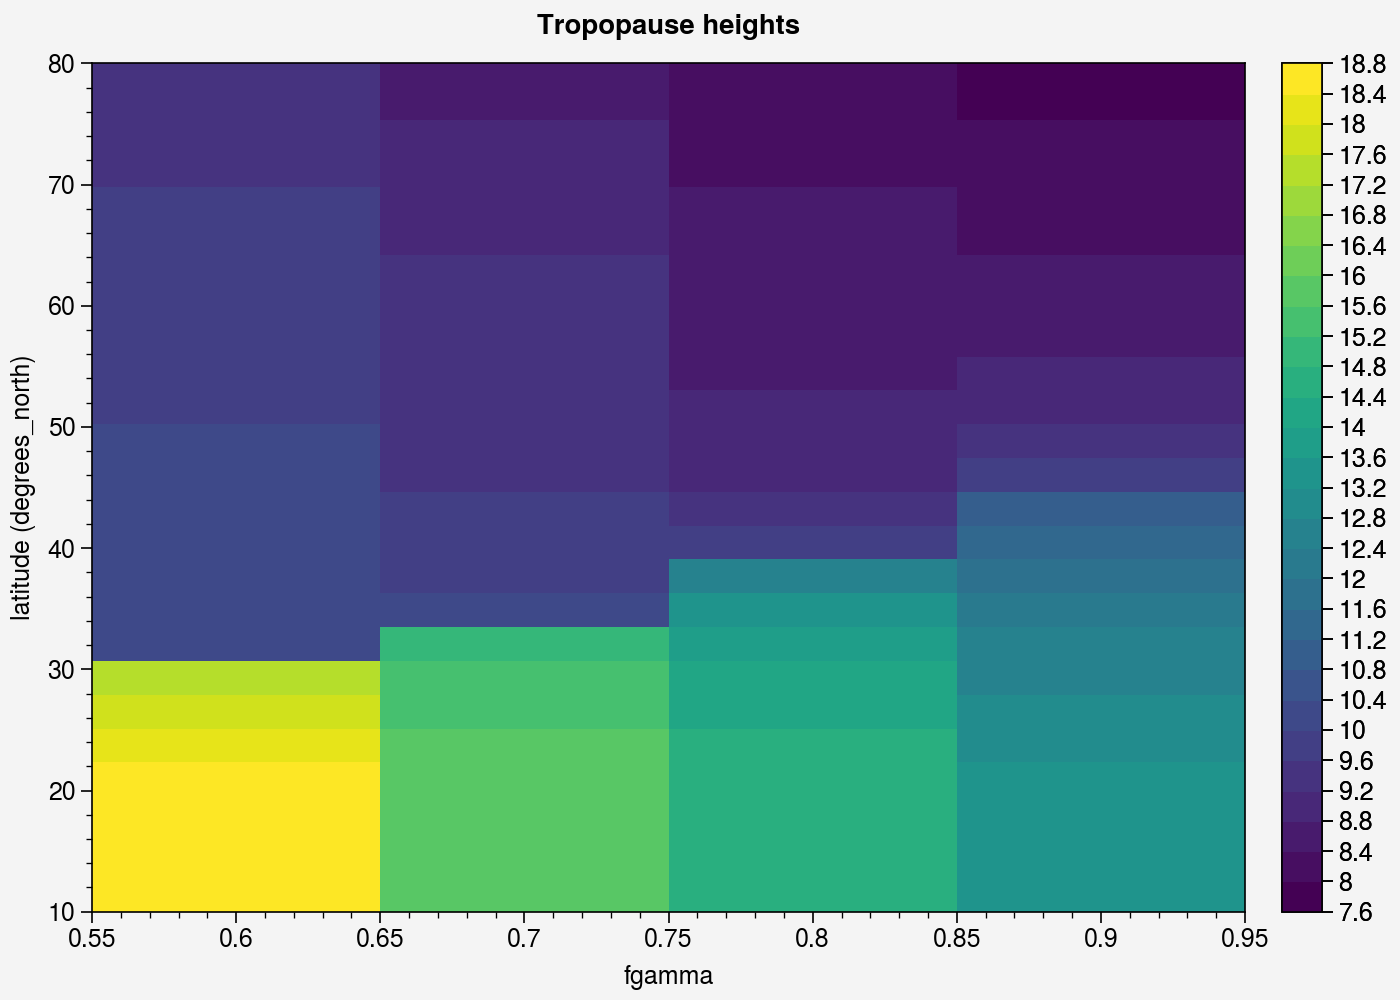

In [16]:
fig, ax = plot_tp_height_intercomp(ds_zm, exp_names)
fig.savefig(f'Intercomparison_ztp.{plot_format}')

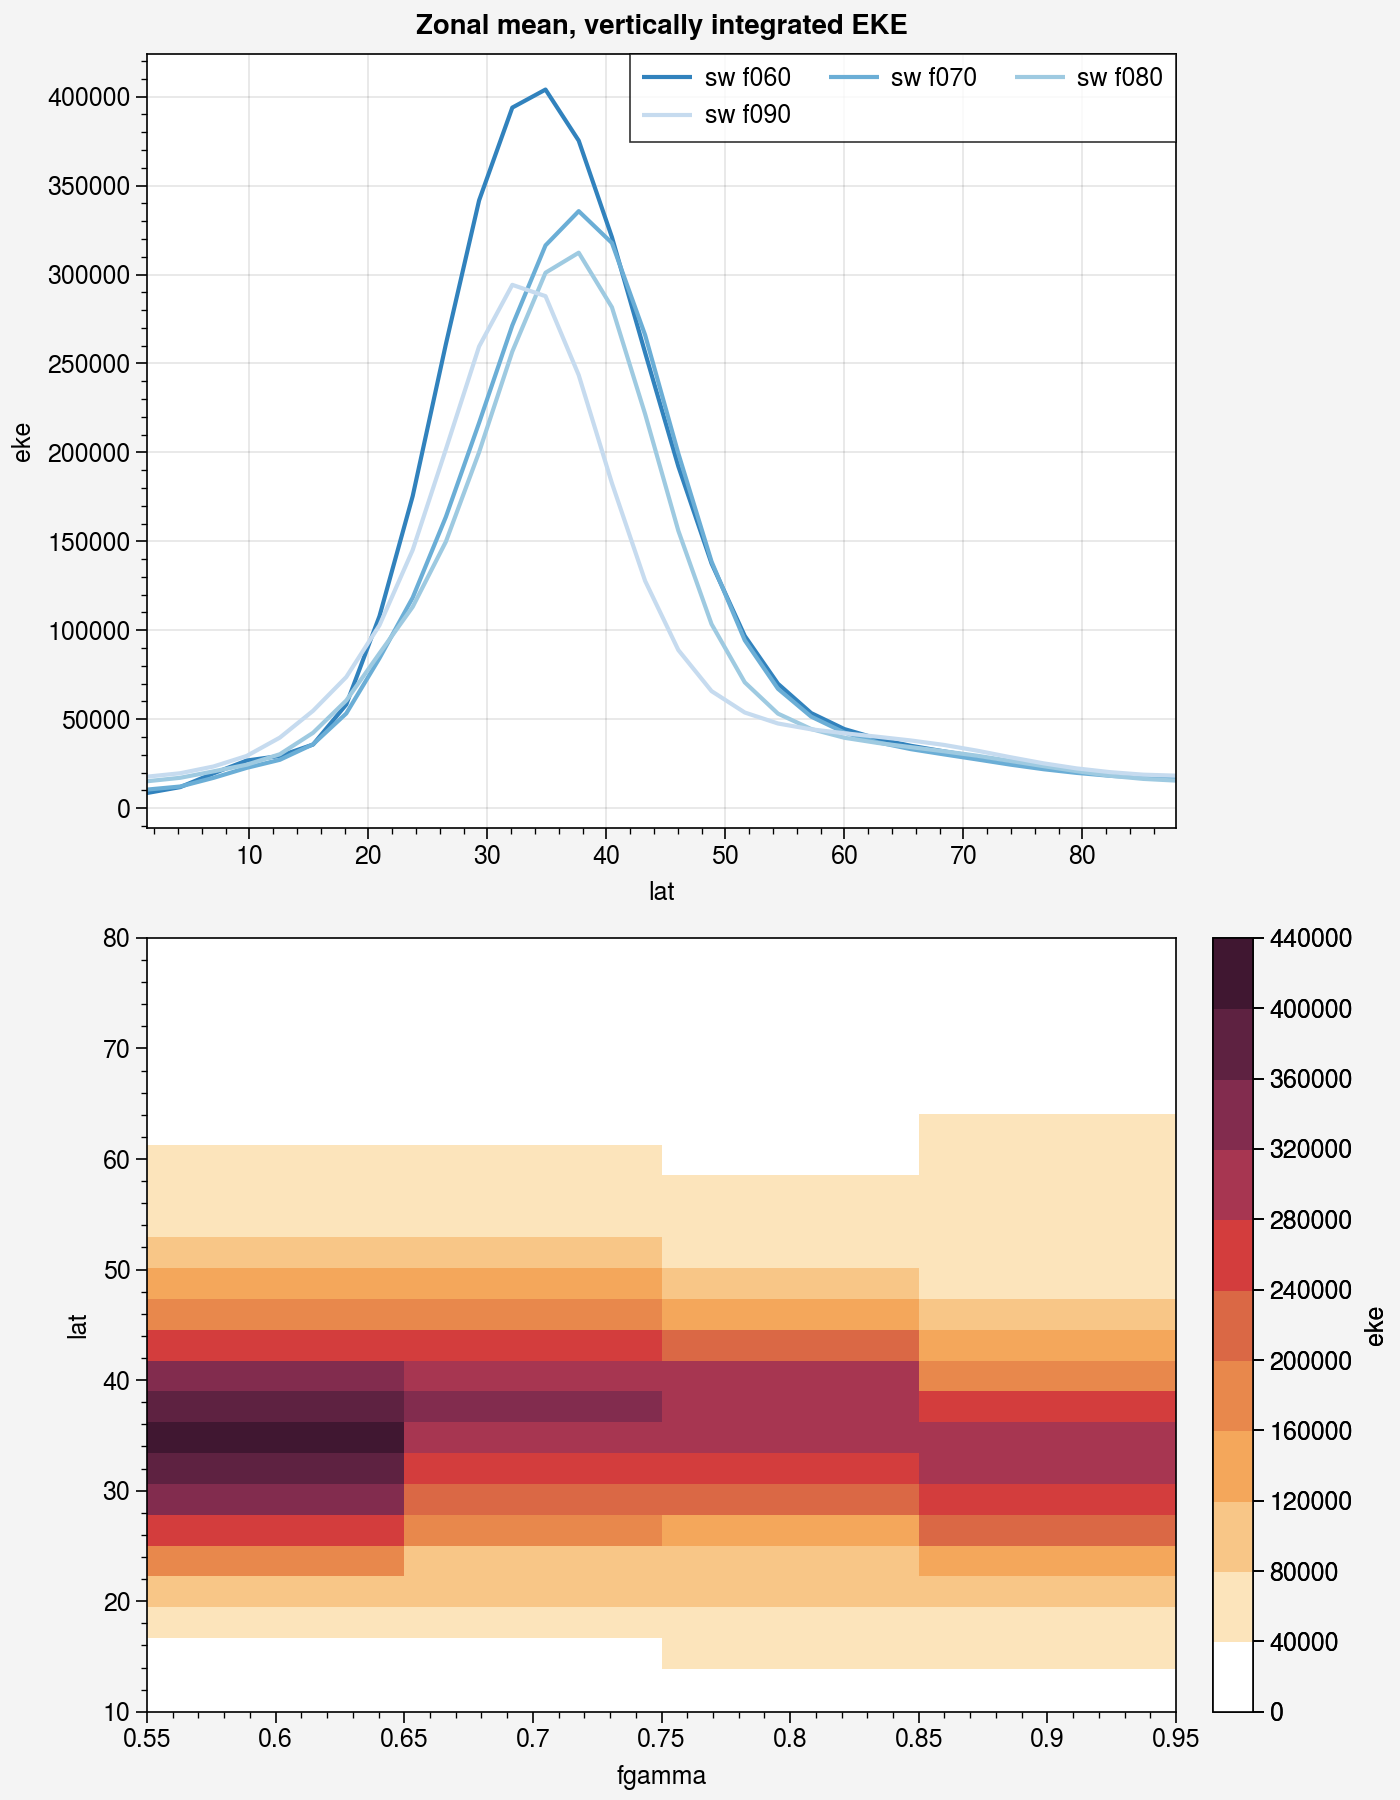

In [17]:
def plot_eke_int_intercomp(ds_zm, exp_names, fig=None, ax=None,  p0=50, p1=1000, linestyle='solid'):
    
    if fig is None:
        fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Zonal mean, vertically integrated EKE', share=False)

    ds = ds_zm.sel(plev=slice(p0,p1)).mean('time').groupby(np.abs(ds_zm.lat)).mean()
    weights = vertical_weights(ds)
    lats = ds.lat
    fgs = np.array([get_fgamma_from(en) for en in exp_names])
    
    eke = ds.eke.weighted(weights).sum('plev')

    for en in exp_names:
        setup = get_setup_from(en).lower()
        label = f'{setup} {en[-4:]}'
        ax[0].plot(ds.lat, ds.sel(exp_name=en).eke.weighted(weights).sum('plev'),
                   cycle='tab20c', linestyle=linestyle, label=label)
    ax[1].pcolormesh(fgs, lats, eke, colorbar='right')

    ax[0].legend()

    ax[1].set_xlabel('fgamma')
    ax[1].set_ylim([10, 80])
    
    return fig, ax 

fig, ax = pplt.subplots(nrows = 2, ncols = 1, figsize = (7, 9), figtitle='Zonal mean, vertically integrated EKE', share=False)

fig, ax = plot_eke_int_intercomp(ds_zm, exp_names, fig=fig, ax=ax)
    
fig.savefig(f'Intercomparison_vert_int_eke.{plot_format}')

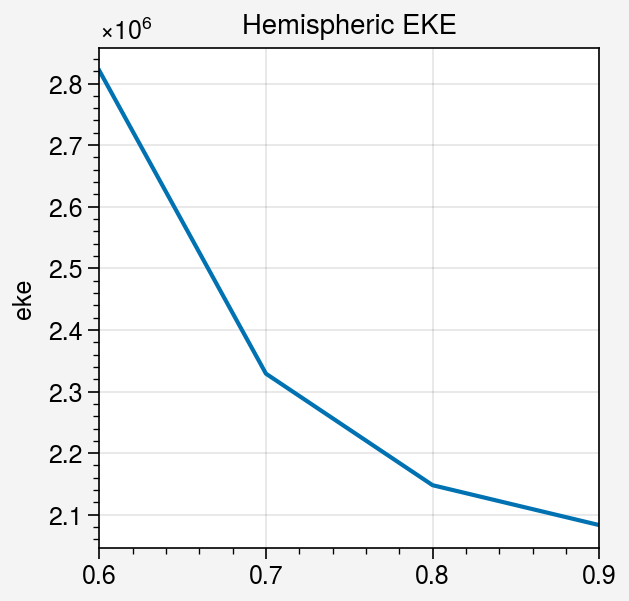

In [18]:
fgs = np.array([get_fgamma_from(en) for en in exp_names])
ds = ds_zm.sel(plev=slice(50,1000)).mean('time').groupby(np.abs(ds_zm.lat)).mean()
hem_eke = ds.eke.weighted(full_weights).sum(['plev','lat'])

fig, ax = pplt.subplots(title='Hemispheric EKE')

ax.plot(fgs, hem_eke)

fig.savefig(f'Intercomparison_hem_eke.{plot_format}')

### Held & Hou Scaling

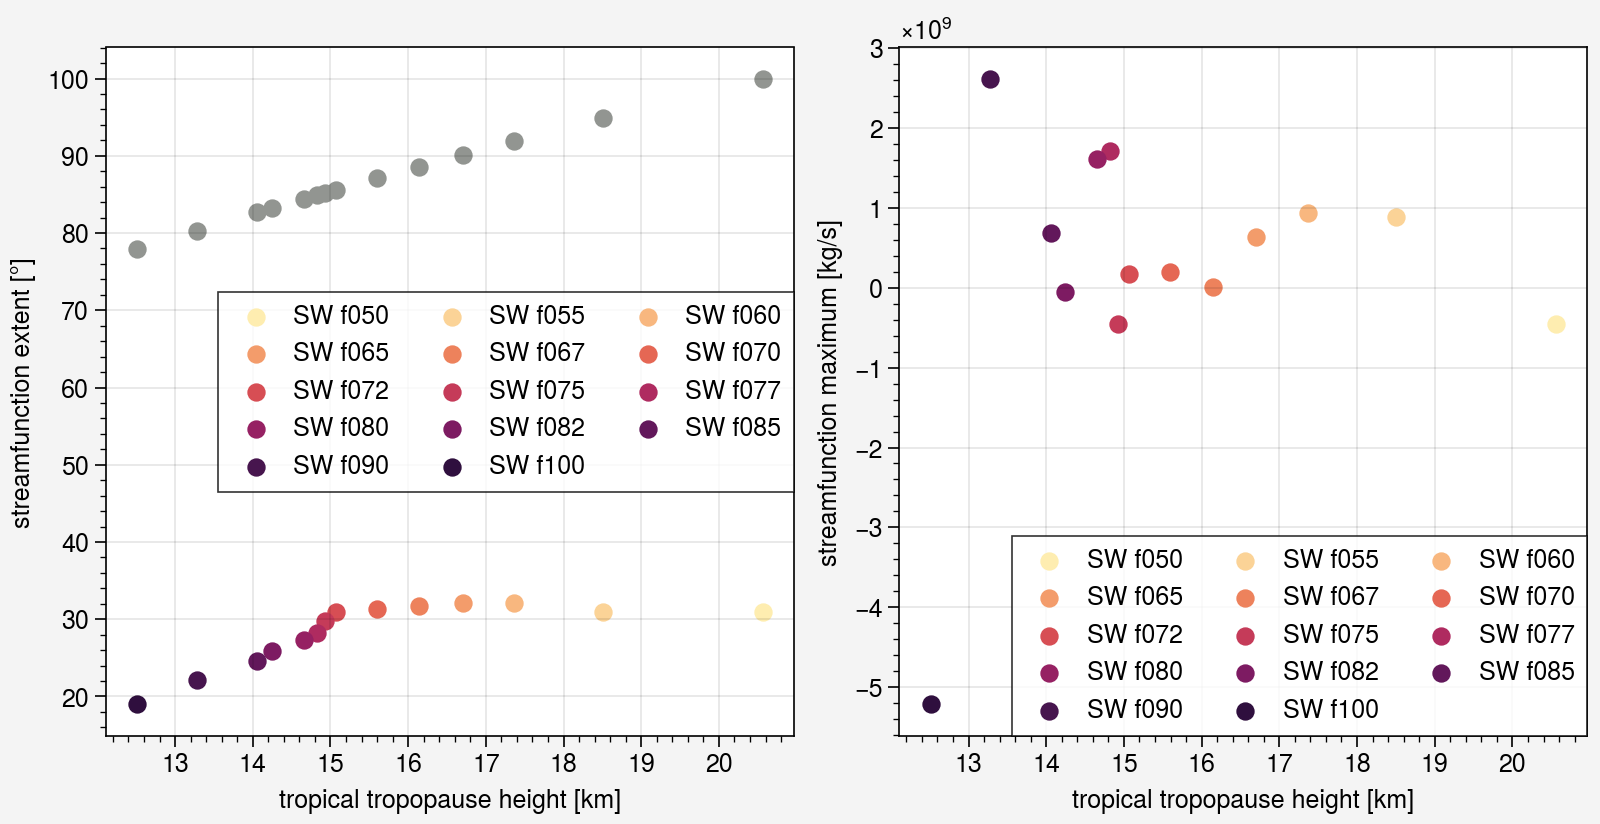

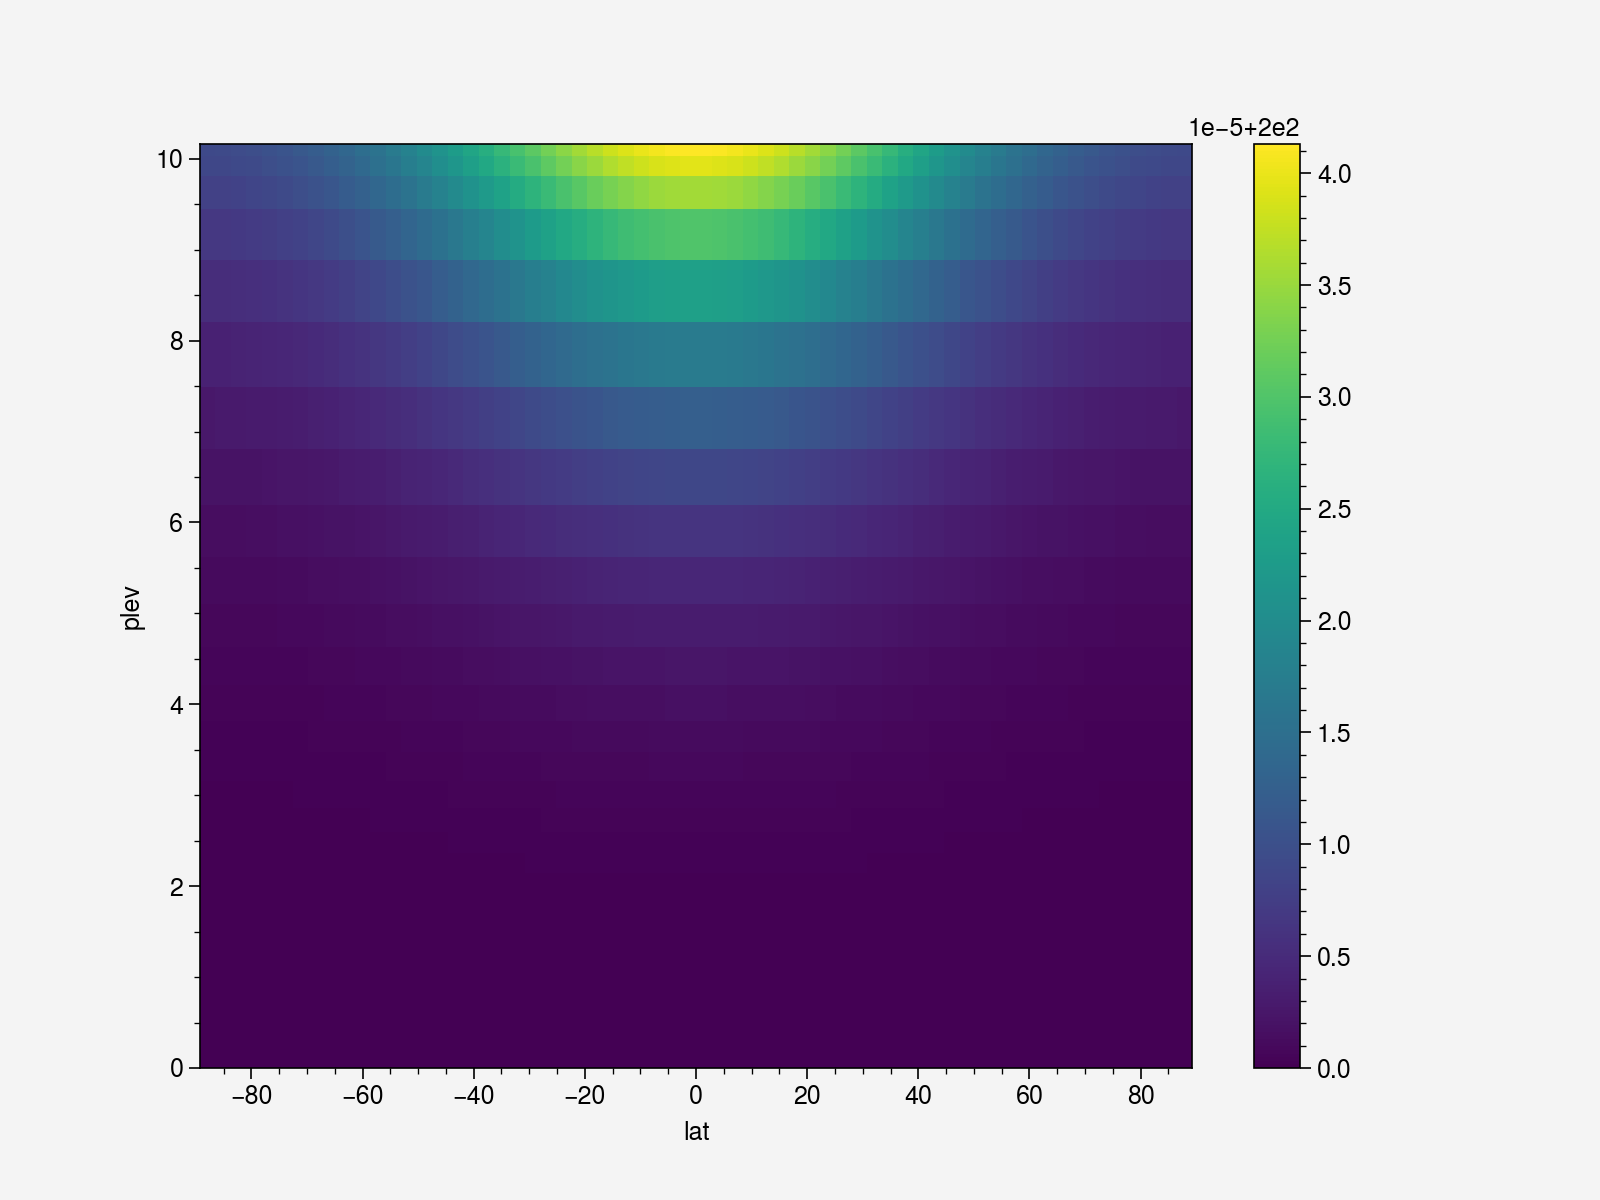

In [6]:
ds = ds_zm
ds_diagn = ds_diagn.sel(exp_name = exp_names)

n = len(exp_names)
cycle = pplt.Cycle('matter', n, )
fig, ax = pplt.subplots(figwidth=8, ncols=2, share=False)
fi, a1 = plt.subplots()
cycle_colors = cycle.by_key()['color']

for i, exp_name in enumerate(exp_names):
    tp_height = ds.ztp.sel(exp_name=exp_name, lat=slice(10,-10)).mean(['lat'])
    #tp_height = ds.ztp.sel(exp_name=exp_name).max('lat')
    
    setup = get_setup_from(exp_name)
    label = f'{setup} {exp_name[-4:]}'
    
    R = g0 * tp_height / omega_earth**2 / r_e**2
    t_equ = relax_submodel(setup, np.radians(ds_zm.lat), ds_zm.plev)
    #print(t_equ)
    v_weights = vertical_weights(t_equ)
    f_weights = weights(t_equ)
    delta_h = 0.3 * ds_diagn.sel(exp_name=exp_name).Ty_equ.mean() #(t_equ.sel(lat=0, method='nearest') - t_equ.sel(lat=90, method='nearest').values).weighted(v_weights).mean('plev')
    theta_0 = ds_zm.theta.weighted(full_weights).mean() #
    phi_0_hh = (R * delta_h/theta_0) ** 0.5


    ax[0].scatter(tp_height/1000, ds_diagn.sel(exp_name=exp_name).Psi_0.mean('hemisphere'), color=cycle_colors[i], label=label)
    ax[0].scatter(tp_height/1000, np.rad2deg(phi_0_hh), color='gray')
    
    ax[1].scatter(tp_height/1000, ds_diagn.sel(exp_name=exp_name).Psi_max.mean('hemisphere'), color=cycle_colors[i], label=label)

ax[0].set_ylabel('streamfunction extent [°]')
ax[0].set_xlabel('tropical tropopause height [km]')
ax[1].set_ylabel('streamfunction maximum [kg/s]')
ax[1].set_xlabel('tropical tropopause height [km]')

for a in ax:
    a.legend()
    
t_equ.plot(ax=a1)

fig.savefig(f'Intercomparison_held_hou_scalings.{plot_format}')

In [189]:
theta_0

<xarray.DataArray ()>
array(nan)

## Calculation of Diagnostics

### Parameters

In [6]:
for exp_name in exp_names:
    df_diagn.loc[(exp_name,),'f_gamma'] = get_fgamma_from(exp_name)


### EDJ and STJ related

In [36]:
j = 0
#fig, ax = pplt.subplots(nrows=len(exp_names))
for exp_name in exp_names:
    ds = ds_zm.sel(exp_name=exp_name).resample(time='1M').mean('time')
    ds = ds.sel(time=ds.time[::2])    
    
    nt = ds.time.size
    edj_lats = np.zeros((nt,2))
    stj_lats = np.zeros((nt,2))
    
    edj_plevs = np.zeros(nt)
    stj_plevs = np.zeros(nt)

    for i in range(nt):
        edj_lats[i], stj_lats[i], edj_plevs[i], stj_plevs[i] = calc_jet_lats(ds.um1.isel(time=i))
    
    edj_lat = np.mean(edj_lats, axis = 0)
    stj_lat = np.mean(stj_lats, axis = 0)
    edj_plev = np.mean(edj_plevs)
    stj_plev = np.mean(stj_plevs)
    
    #ax[j].scatter(edj_lats, stj_lats)
    j += 1
    jet_corr_nh = np.corrcoef(stj_lats[:,0], edj_lats[:,0])[0,1]
    jet_corr_sh = np.corrcoef(stj_lats[:,1], edj_lats[:,1])[0,1]
    df_diagn.loc[(exp_name, 'NH'),'jet_corr'] = jet_corr_nh
    df_diagn.loc[(exp_name, 'SH'),'jet_corr'] = jet_corr_sh
    # absolute values so the scatterplots are more informative
    df_diagn.loc[(exp_name,),'edj_lat'] = np.abs(edj_lat)
    df_diagn.loc[(exp_name,),'stj_lat'] = np.abs(stj_lat)

    df_diagn.loc[(exp_name,'NH'),'stj_max'] = ds.um1.sel(plev=stj_plev, method='nearest').mean(['time']).interp(lat=stj_lat[0]).values
    df_diagn.loc[(exp_name,'SH'),'stj_max'] = ds.um1.sel(plev=stj_plev, method='nearest').mean(['time']).interp(lat=stj_lat[1]).values
    df_diagn.loc[(exp_name,'NH'),'edj_max'] = ds.um1.sel(plev=edj_plev, method='nearest').mean(['time']).interp(lat=edj_lat[0]).values
    df_diagn.loc[(exp_name,'SH'),'edj_max'] = ds.um1.sel(plev=edj_plev, method='nearest').mean(['time']).interp(lat=edj_lat[1]).values
    df_diagn.loc[(exp_name,),'stj_plev'] = stj_plev
    
    df_diagn.loc[(exp_name,'NH'),'edj_ep_bdgt'] = edj_ep_flux_budget.sel(exp_name=exp_name, hemisphere='NH').mean('time')
    df_diagn.loc[(exp_name,'SH'),'edj_ep_bdgt'] = edj_ep_flux_budget.sel(exp_name=exp_name, hemisphere='SH').mean('time')
    
df_diagn['jet_sep'] = np.abs(df_diagn.stj_lat - df_diagn.edj_lat)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/sw/s

### Hadley Cell

In [8]:
for exp_name in exp_names:
    ds = ds_zm.sel(exp_name=exp_name)
    da_psi = ds.psi
    
    df_diagn.loc[(exp_name,'NH'),'Psi_max'] = da_psi.sel(lat=slice(90,0)).max().values
    df_diagn.loc[(exp_name,'SH'),'Psi_max'] = da_psi.sel(lat=slice(0,-90)).min().values
    
    df_diagn.loc[(exp_name,),'Psi_0'] = np.abs(tropdm.TropD_Metric_PSI(ds.vm1.mean('time').values, ds.lat.values, ds.plev.values))


In [9]:
df_diagn

Ty_actual     Ty_eff Ty_equ    edj_lat    edj_max  \
exp_name       hemisphere                                                      
EMIL_SW90_f050 NH          37.885824  90.232679     90  47.439944   5.319676   
               SH          38.031697  90.232679     90  46.044721   6.576468   
EMIL_SW90_f055 NH          37.071089  90.232679     90  50.230478   6.972635   
               SH          37.312731  90.232679     90  49.765404   7.814119   
EMIL_SW90_f060 NH          37.267265  90.232679     90  49.765401   8.646901   
               SH          37.139622  90.232679     90  49.765401   8.606471   
EMIL_SW90_f065 NH          37.424347  90.232679     90  48.835236   9.472293   
               SH          38.363768  90.232679     90  47.905069   9.943561   
EMIL_SW90_f067 NH          37.772746  90.232679     90  46.509813  10.122219   
               SH          37.145171  90.232679     90  47.905069   9.918398   
EMIL_SW90_f070 NH          36.635183  90.232679     90  45.579639  10.192267   
               SH          37.708621  90.232679     90  46.044724  10.296381   
EMIL_SW90_f072 NH          36.983766  90.232679     90  44.184373  10.822990   
               SH          37.254867  90.232679     90  45.579639  10.762449   
EMIL_SW90_f075 NH          36.580995  90.232679     90  42.324011  10.105296   
               SH          36.200791  90.232679     90  44.184373  10.734316   
EMIL_SW90_f077 NH          35.352717  90.232679     90  39.533463   9.748319   
               SH          36.044476  90.232679     90  40.463642   9.726487   
EMIL_SW90_f080 NH          35.627408  90.232679     90  39.533463  10.123677   
               SH          35.558814  90.232679     90  37.673087   9.349949   
EMIL_SW90_f082 NH          36.359253  90.232679     90  35.812711   9.423215   
               SH          35.736382  90.232679     90  35.812709   8.552487   
EMIL_SW90_f085 NH          36.359070  90.232679     90  34.882521   9.699236   
               SH          36.681719  90.232679     90  33.952327   8.368544   
EMIL_SW90_f090 NH          37.847928  90.232679     90  30.696652   8.359458   
               SH          37.281586  90.232679     90  31.626846   8.869662   
EMIL_SW90_f100 NH          39.738145  90.232679     90  28.836260   7.643563   
               SH          39.906232  90.232679     90  28.836261   8.045482   
EMIL_SW60_f050 NH          39.609770  50.129264     50  42.789104   3.642815   
               SH          37.061050  50.129264     50  44.649460   3.765018   
EMIL_SW60_f060 NH          32.876611  60.155122     60  46.044718   5.933156   
               SH          32.667084  60.155122     60  46.509808   6.237696   
EMIL_SW60_f070 NH          31.176327  70.180967     70  44.649459   7.401185   
               SH          31.021193  70.180967     70  44.882003   7.375178   
EMIL_SW60_f080 NH          27.516325  80.206821     80  35.580163   7.376770   
               SH          27.425184  80.206821     80  35.580162   7.214632   
EMIL_SW60_f090 NH          25.684378  90.232679     90  28.371162   6.643884   
               SH          25.859072  90.232679     90  27.673515   6.689528   
EMIL_SW60_f100 NH          26.482944   0.000000      0  26.975867   6.304674   
               SH          26.485644   0.000000      0  26.510768   6.437920   
EMIL_SW120f050 NH                NaN        NaN    NaN  52.323340   9.354968   
               SH                NaN        NaN    NaN  51.858258   9.576687   
EMIL_SW120f060 NH                NaN        NaN    NaN  49.067772  11.449527   
               SH                NaN        NaN    NaN  49.300320  11.742400   
EMIL_SW120f070 NH                NaN        NaN    NaN  45.579639  12.521650   
               SH                NaN        NaN    NaN  45.579636  12.592355   
EMIL_SW120f080 NH                NaN        NaN    NaN  40.696193  11.995023   
               SH                NaN        NaN    NaN  41.161285  11.990465   
EMIL_SW120f090 NH          

### Meridional temperature gradients & cold point

In [10]:
for exp_name in exp_names:
    ds = ds_zm.sel(exp_name=exp_name)
    ty = get_ty_from(exp_name)
    setup = get_setup_from(exp_name)
    l0 = get_l0_from(exp_name)

    da_sfct = ds.tm1.sel(lat=slice(10,-10)).mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"})
    l0_act = np.round(tropdf.TropD_Calculate_MaxLat(da_sfct.values, da_sfct.lat.values), decimals=2)
    
    ## Calculation of hemispheric temperature difference on NH
    df_diagn.loc[(exp_name,'NH'),'Ty_actual'] = (
        ds.tm1.mean('time').dropna('plev').interp(lat=l0_act, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}).values - 
        ds.tm1.mean('time').dropna('plev').interp(lat=90, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}).values
    )

    ## Calculation of hemispheric temperature difference on SH
    df_diagn.loc[(exp_name,'SH'),'Ty_actual'] = (
        ds.tm1.mean('time').dropna('plev').interp(lat=l0_act, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}).values - 
        ds.tm1.mean('time').dropna('plev').interp(lat=-90, plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}).values
    )

    ## Calculation of hemispheric temperature difference from T_equ
    df_diagn.loc[(exp_name,),'Ty_eff'] = calc_Ty_eff(setup, ty, l0, ds.lat)[:2]
    t_equ_sfc = calc_Ty_eff(setup, ty, l0, ds.lat)[2]

    ## Calculation of the latitudes of the surface temperature maxima in T_equ and the actual T_sfc  
    df_diagn.loc[(exp_name,),'lat_0'] = l0
    df_diagn.loc[(exp_name,),'lat_0_actual'] = float(l0_act)

    ## Saving the nominal temperature difference 
    df_diagn.loc[(exp_name,),'Ty_equ'] = ty
    
    ## Cold point temperature is not a hemispheric metric. Same value stored in both
    df_diagn.loc[(exp_name,),'T_coldpoint'] = ds.tm1.mean('time').min()



In [11]:
df_diagn

Ty_actual     Ty_eff Ty_equ    edj_lat    edj_max  \
exp_name       hemisphere                                                      
EMIL_SW90_f050 NH          37.885824  90.232679     90  47.439944   5.319676   
               SH          38.031697  90.232679     90  46.044721   6.576468   
EMIL_SW90_f055 NH          37.071089  90.232679     90  50.230478   6.972635   
               SH          37.312731  90.232679     90  49.765404   7.814119   
EMIL_SW90_f060 NH          37.267265  90.232679     90  49.765401   8.646901   
               SH          37.139622  90.232679     90  49.765401   8.606471   
EMIL_SW90_f065 NH          37.424347  90.232679     90  48.835236   9.472293   
               SH          38.363768  90.232679     90  47.905069   9.943561   
EMIL_SW90_f067 NH          37.772746  90.232679     90  46.509813  10.122219   
               SH          37.145171  90.232679     90  47.905069   9.918398   
EMIL_SW90_f070 NH          36.635183  90.232679     90  45.579639  10.192267   
               SH          37.708621  90.232679     90  46.044724  10.296381   
EMIL_SW90_f072 NH          36.983766  90.232679     90  44.184373  10.822990   
               SH          37.254867  90.232679     90  45.579639  10.762449   
EMIL_SW90_f075 NH          36.580995  90.232679     90  42.324011  10.105296   
               SH          36.200791  90.232679     90  44.184373  10.734316   
EMIL_SW90_f077 NH          35.352717  90.232679     90  39.533463   9.748319   
               SH          36.044476  90.232679     90  40.463642   9.726487   
EMIL_SW90_f080 NH          35.627408  90.232679     90  39.533463  10.123677   
               SH          35.558814  90.232679     90  37.673087   9.349949   
EMIL_SW90_f082 NH          36.359253  90.232679     90  35.812711   9.423215   
               SH          35.736382  90.232679     90  35.812709   8.552487   
EMIL_SW90_f085 NH          36.359070  90.232679     90  34.882521   9.699236   
               SH          36.681719  90.232679     90  33.952327   8.368544   
EMIL_SW90_f090 NH          37.847928  90.232679     90  30.696652   8.359458   
               SH          37.281586  90.232679     90  31.626846   8.869662   
EMIL_SW90_f100 NH          39.738145  90.232679     90  28.836260   7.643563   
               SH          39.906232  90.232679     90  28.836261   8.045482   
EMIL_SW60_f050 NH          39.609770  50.129264     50  42.789104   3.642815   
               SH          37.061050  50.129264     50  44.649460   3.765018   
EMIL_SW60_f060 NH          32.876611  60.155122     60  46.044718   5.933156   
               SH          32.667084  60.155122     60  46.509808   6.237696   
EMIL_SW60_f070 NH          31.176327  70.180967     70  44.649459   7.401185   
               SH          31.021193  70.180967     70  44.882003   7.375178   
EMIL_SW60_f080 NH          27.516325  80.206821     80  35.580163   7.376770   
               SH          27.425184  80.206821     80  35.580162   7.214632   
EMIL_SW60_f090 NH          25.684378  90.232679     90  28.371162   6.643884   
               SH          25.859072  90.232679     90  27.673515   6.689528   
EMIL_SW60_f100 NH          26.482944   0.000000      0  26.975867   6.304674   
               SH          26.485644   0.000000      0  26.510768   6.437920   
EMIL_SW120f050 NH          46.281759  46.704219     50  52.323340   9.354968   
               SH          47.674547  53.695239     50  51.858258   9.576687   
EMIL_SW120f060 NH          49.262769  56.045067     60  49.067772  11.449527   
               SH          49.552906  64.434284     60  49.300320  11.742400   
EMIL_SW120f070 NH          53.836431  65.385908     70  45.579639  12.521650   
               SH          54.466594  75.173331     70  45.579636  12.592355   
EMIL_SW120f080 NH          54.349179  74.726745     80  40.696193  11.995023   
               SH          54.559680  85.912386     80  41.161285  11.990465   
EMIL_SW120f090 NH          

### Eddy momentum transport related

In [12]:
for exp_name in exp_names:
    ds = ds_tp.vu_et.weighted(weights=vert_weights).mean('plev').sel(exp_name=exp_name)
    #ds_vuet_dg_nh = max_latitude(ds.sel(lat=slice(90,0)))
    #ds_vuet_dg_sh = max_latitude(-ds.sel(lat=slice(0,-90)))
    
    vuet_max_lat_nh = calculate_max_lat(ds.sel(lat=slice(90,0)).mean('time'))
    vuet_max_lat_sh = calculate_max_lat(-ds.sel(lat=slice(0,-90)).mean('time'))
    
    #print(ds_vuet_dg_nh.mean('time'), ds_vuet_dg_sh.mean('time'))
    #print(vuet_max_lat_nh, vuet_max_lat_sh)
    
    df_diagn.loc[(exp_name,'SH'),'vuet_max'] = (ds.sel(lat=slice(90,0)).mean('time')).max('lat').values
    df_diagn.loc[(exp_name,'NH'),'vuet_max'] = (-ds.sel(lat=slice(0,-90)).mean('time')).max('lat').values
    
    df_diagn.loc[(exp_name,),'vuet_lat_max'] = np.abs([vuet_max_lat_nh, vuet_max_lat_sh])

    factor = 0.5*np.pi*r_e * 2*np.pi*r_e
    df_diagn.loc[(exp_name,'NH'),'vuet_total'] = factor * (ds.sel(lat=slice(90,0)).mean('time')).sum('lat').values
    df_diagn.loc[(exp_name,'SH'),'vuet_total'] = factor * (-ds.sel(lat=slice(0,-90)).mean('time')).sum('lat').values

In [13]:
df_diagn.sort_index()

Ty_actual     Ty_eff Ty_equ    edj_lat    edj_max  \
exp_name       hemisphere                                                      
EMIL_SW120f050 NH          46.281759  46.704219     50  52.323340   9.354968   
               SH          47.674547  53.695239     50  51.858258   9.576687   
EMIL_SW120f060 NH          49.262769  56.045067     60  49.067772  11.449527   
               SH          49.552906  64.434284     60  49.300320  11.742400   
EMIL_SW120f070 NH          53.836431  65.385908     70  45.579639  12.521650   
               SH          54.466594  75.173331     70  45.579636  12.592355   
EMIL_SW120f080 NH          54.349179  74.726745     80  40.696193  11.995023   
               SH          54.559680  85.912386     80  41.161285  11.990465   
EMIL_SW120f090 NH          56.035780  84.067596     90  35.580163  10.524835   
               SH          56.131044  96.651433     90  35.580162  10.664272   
EMIL_SW120f100 NH          55.830145   0.000000      0  32.324491   8.756689   
               SH          55.638241   0.000000      0  32.557040   8.935597   
EMIL_SW60_f050 NH          39.609770  50.129264     50  42.789104   3.642815   
               SH          37.061050  50.129264     50  44.649460   3.765018   
EMIL_SW60_f060 NH          32.876611  60.155122     60  46.044718   5.933156   
               SH          32.667084  60.155122     60  46.509808   6.237696   
EMIL_SW60_f070 NH          31.176327  70.180967     70  44.649459   7.401185   
               SH          31.021193  70.180967     70  44.882003   7.375178   
EMIL_SW60_f080 NH          27.516325  80.206821     80  35.580163   7.376770   
               SH          27.425184  80.206821     80  35.580162   7.214632   
EMIL_SW60_f090 NH          25.684378  90.232679     90  28.371162   6.643884   
               SH          25.859072  90.232679     90  27.673515   6.689528   
EMIL_SW60_f100 NH          26.482944   0.000000      0  26.975867   6.304674   
               SH          26.485644   0.000000      0  26.510768   6.437920   
EMIL_SW90_f050 NH          37.885824  90.232679     90  47.439944   5.319676   
               SH          38.031697  90.232679     90  46.044721   6.576468   
EMIL_SW90_f055 NH          37.071089  90.232679     90  50.230478   6.972635   
               SH          37.312731  90.232679     90  49.765404   7.814119   
EMIL_SW90_f060 NH          37.267265  90.232679     90  49.765401   8.646901   
               SH          37.139622  90.232679     90  49.765401   8.606471   
EMIL_SW90_f065 NH          37.424347  90.232679     90  48.835236   9.472293   
               SH          38.363768  90.232679     90  47.905069   9.943561   
EMIL_SW90_f067 NH          37.772746  90.232679     90  46.509813  10.122219   
               SH          37.145171  90.232679     90  47.905069   9.918398   
EMIL_SW90_f070 NH          36.635183  90.232679     90  45.579639  10.192267   
               SH          37.708621  90.232679     90  46.044724  10.296381   
EMIL_SW90_f072 NH          36.983766  90.232679     90  44.184373  10.822990   
               SH          37.254867  90.232679     90  45.579639  10.762449   
EMIL_SW90_f075 NH          36.580995  90.232679     90  42.324011  10.105296   
               SH          36.200791  90.232679     90  44.184373  10.734316   
EMIL_SW90_f077 NH          35.352717  90.232679     90  39.533463   9.748319   
               SH          36.044476  90.232679     90  40.463642   9.726487   
EMIL_SW90_f080 NH          35.627408  90.232679     90  39.533463  10.123677   
               SH          35.558814  90.232679     90  37.673087   9.349949   
EMIL_SW90_f082 NH          36.359253  90.232679     90  35.812711   9.423215   
               SH          35.736382  90.232679     90  35.812709   8.552487   
EMIL_SW90_f085 NH          36.359070  90.232679     90  34.882521   9.699236   
               SH          36.681719  90.232679     90  33.952327   8.368544   
EMIL_SW90_f090 NH          

In [37]:
os.chdir(csv_path)
df_diagn.to_csv('diagnostics.csv')
os.chdir(outpath)

In [38]:
#idx = pd.IndexSlice
#df_diagn.loc[idx[exp_names,:],:].to_csv('diagnostics.csv')

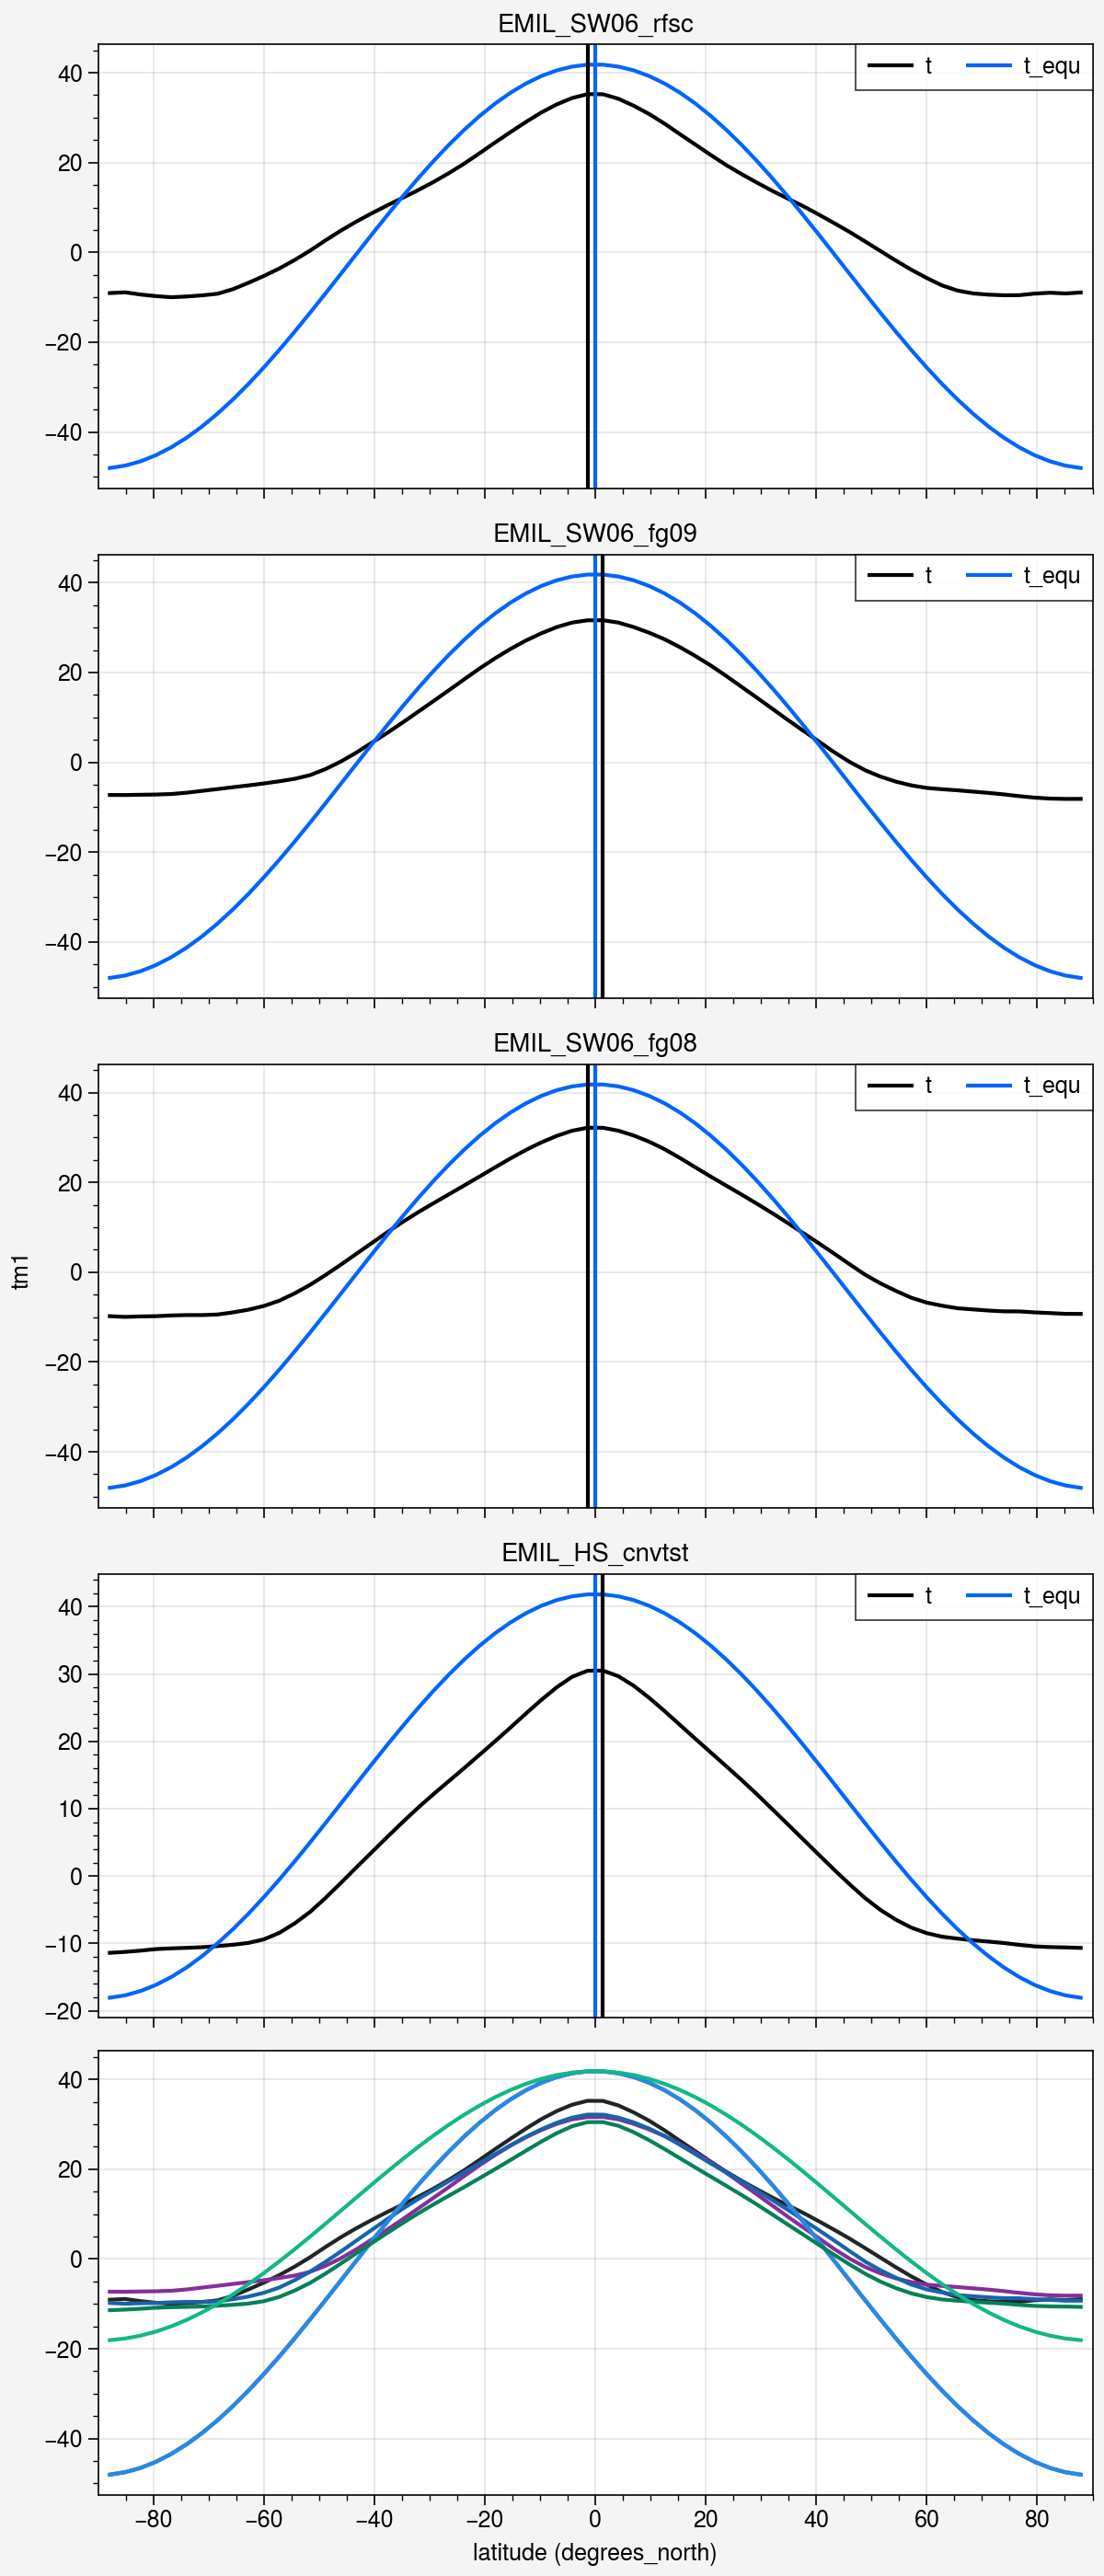

In [8]:
colors=['gray9', 'grape9', 'blue9', 'teal9', 'pink9']
colors_eq=['gray6', 'grape6', 'blue6', 'teal6', 'pink6']

fig, ax = pplt.subplots(figsize=(6,14), nrows=len(exp_names)+1, share=True)

for i, exp_name in enumerate(exp_names):
    ds = ds_zm.sel(exp_name=exp_name)
    ty = get_ty_from(exp_name)
    setup = get_setup_from(exp_name)
    l0 = get_l0_from(exp_name)

    eps= - 12.54
    da_sfct = ds.tm1.mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"})
    l0_act = da_sfct.lat.where(da_sfct == da_sfct.max(), drop=True).values
    
    t_equ_sfc = calc_Ty_eff(setup, ty, l0, ds.lat)[2]
    t_act_sfc = ds.tm1.mean('time').dropna('plev').interp(plev=ds.plev[-1], kwargs={"fill_value": "extrapolate"}) - 273.15
    

    ax[-1].plot(ds.lat, t_act_sfc, color=colors[i])
    ax[-1].plot(ds.lat, t_equ_sfc, color=colors_eq[i])
    #ax[-1].axvline(l0, color=colors_eq[i])
    #ax[-1].axvline(l0_act, color=colors[i])

    ax[i].plot(ds.lat, t_act_sfc, color='black', label='t')
    ax[i].plot(ds.lat, t_equ_sfc, color='bright blue', label='t_equ')
    ax[i].axvline(l0, color='bright blue')
    ax[i].axvline(l0_act, color='black')
    ax[i].set_title(exp_name)

for a in ax[:-1]:
    a.set_xlim([-90,90])
    a.legend()

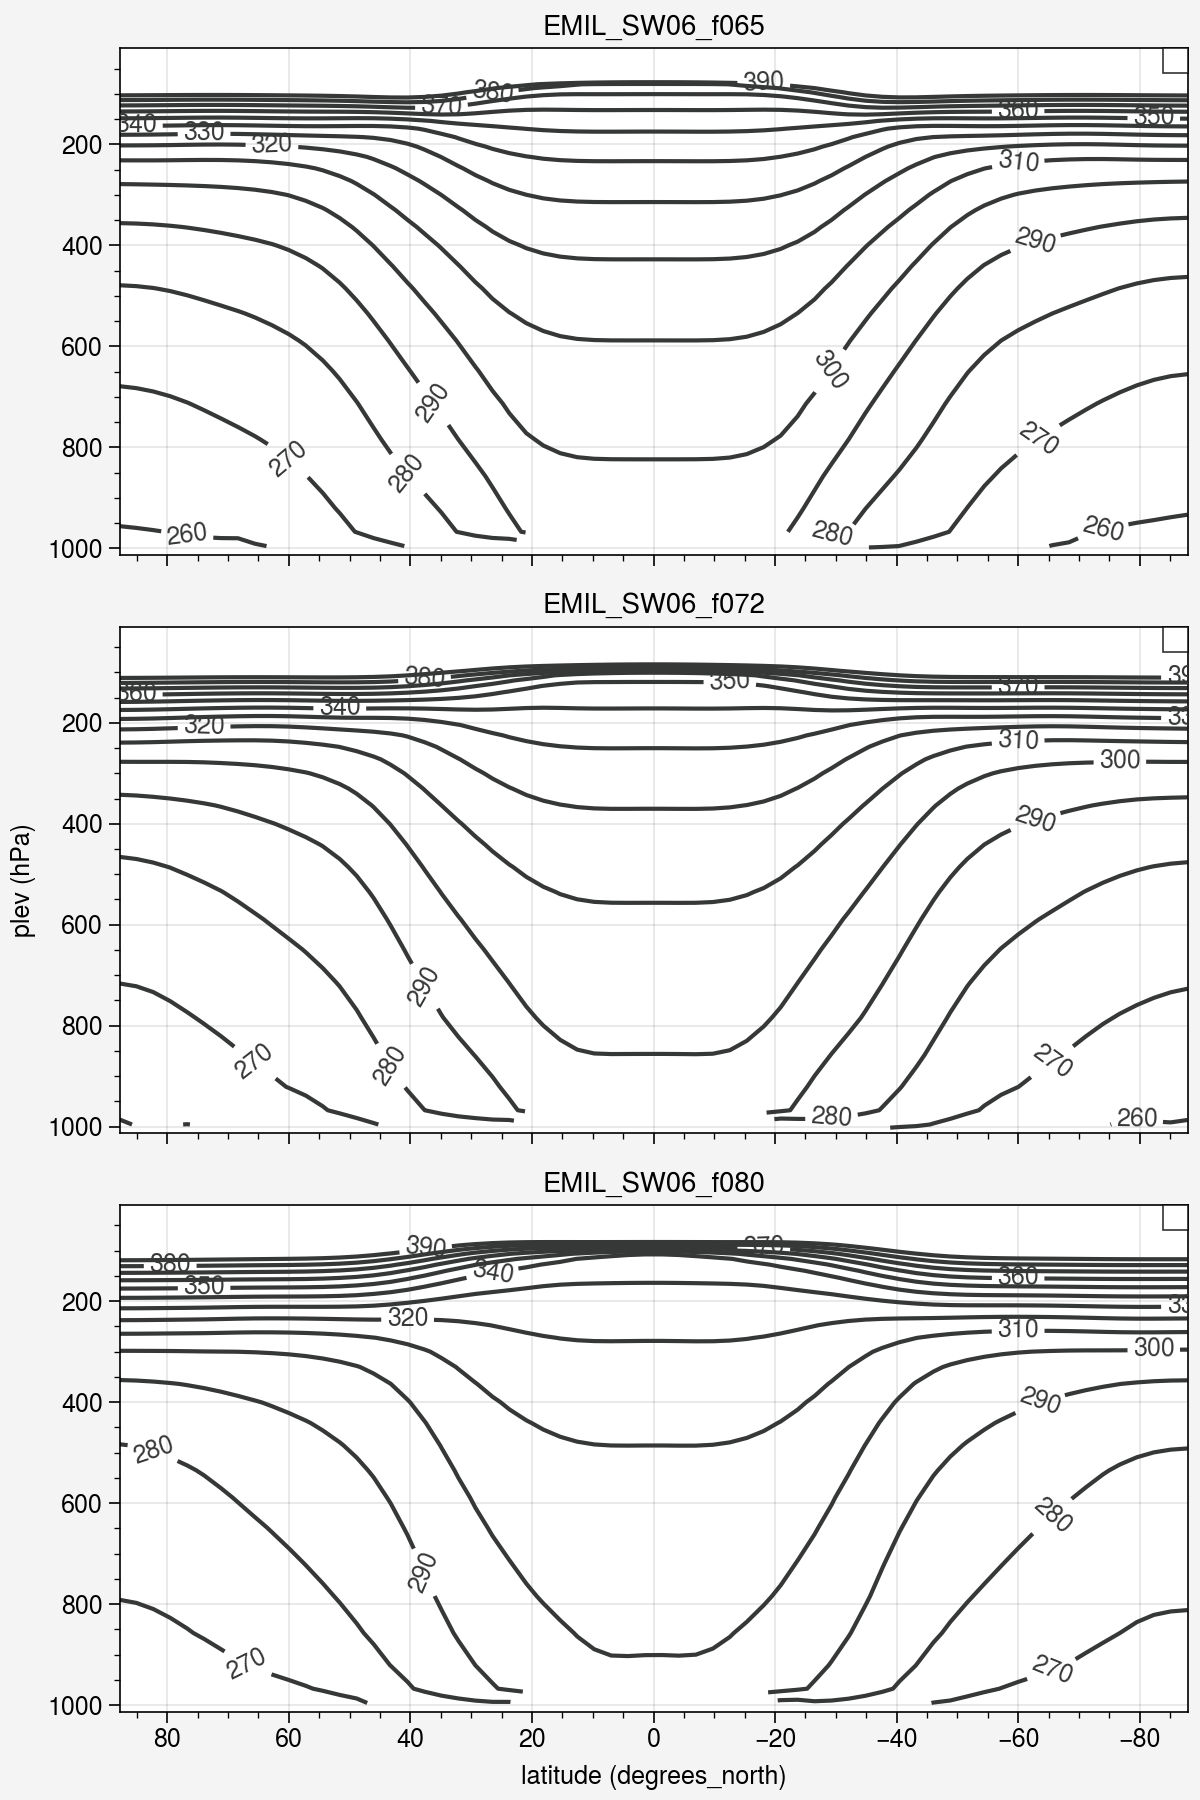

In [18]:
exp_name_sel = exp_names[::3]
fig, ax = pplt.subplots(figsize=(6,3*len(exp_name_sel)), nrows=len(exp_name_sel))

for i,exp_name in enumerate(exp_name_sel):
    
    ds = ds_zm.sel(exp_name=exp_name, plev=slice(20, 1013)).mean('time')
    ty = get_ty_from(exp_name)
    levels=np.arange(220, 390.1, 10)
    
    ax[i].contour(ds.lat, ds.plev, ds.theta, 
               color='dark gray', #alpha = 0.5 + 0.5*ty/100,
               levels=levels, labels=True, label=exp_name[-4:])
    ax[i].set_title(exp_name)

for a in ax:
    a.set_ylim(ylims)
    a.legend()
    
fig.savefig(f'Intercomparison_theta_fields.{plot_format}')

['EMIL_SW06_f065', 'EMIL_SW06_f072', 'EMIL_SW06_f080']


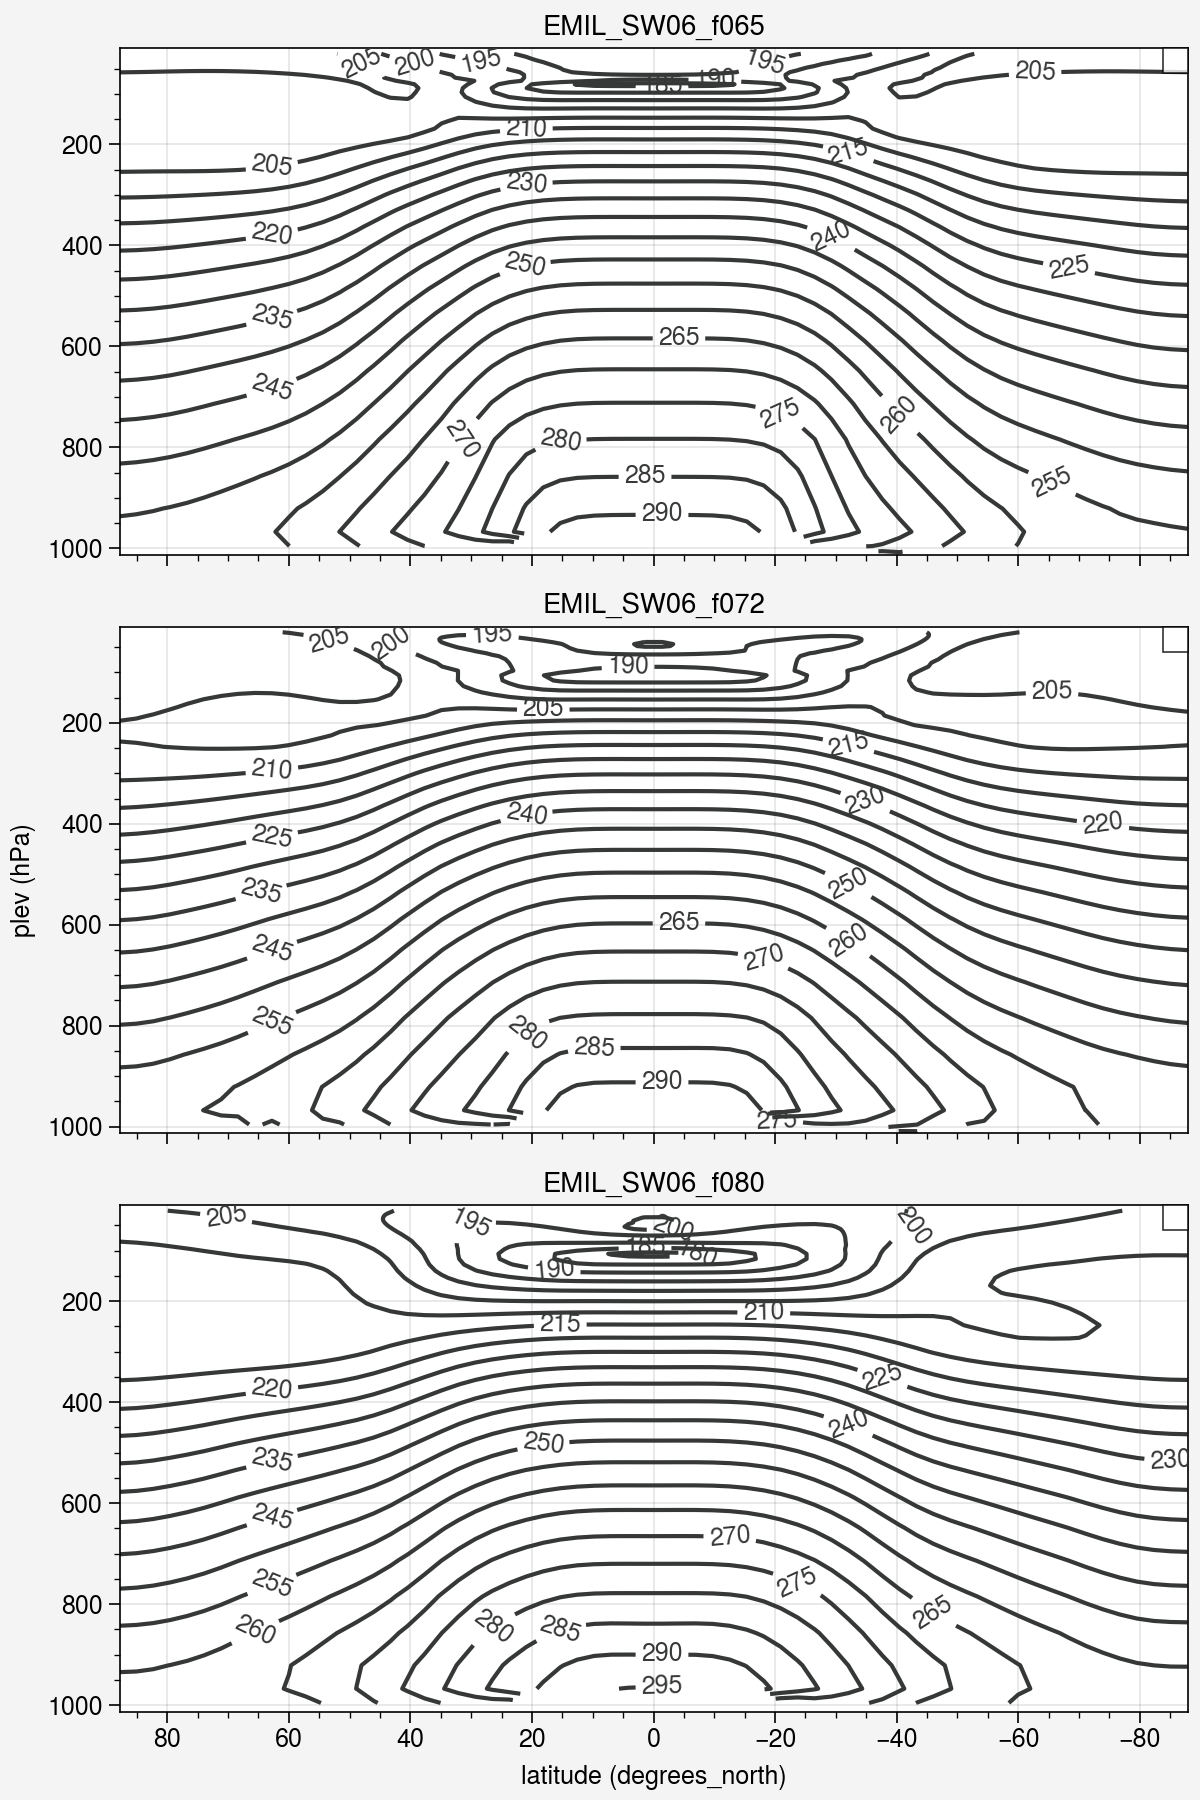

In [19]:
exp_name_sel = exp_names[::3]
print(exp_name_sel)
fig, ax = pplt.subplots(figsize=(6,3*len(exp_name_sel)), nrows=len(exp_name_sel))

for i,exp_name in enumerate(exp_name_sel):
    
    ds = ds_zm.sel(exp_name=exp_name, plev=slice(20, 1013)).mean('time')
    ty = get_ty_from(exp_name)
    levels=np.arange(180, 320.1, 5)
    
    ax[i].contour(ds.lat, ds.plev, ds.tm1, 
               color='dark gray', #alpha = 0.5 + 0.5*ty/100,
               levels=levels, labels=True, label=exp_name[-4:])
    ax[i].set_title(exp_name)

for a in ax:
    a.set_ylim(ylims)
    a.legend()
    
fig.savefig(f'Intercomparison_temperature_fields.{plot_format}')

In [ ]:
ds_js = calc_jet_sep_index(ds_zm.isel(exp_name=1), resample_freq='5D')
ds_js

<xarray.Dataset>
Dimensions:     (hemisphere: 2, time: 74)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-06 ... 2000-12-31
  * hemisphere  (hemisphere) <U2 'NH' 'SH'
Data variables:
    jet_sep     (hemisphere, time) float64 20.16 17.58 17.88 ... 9.009 16.24

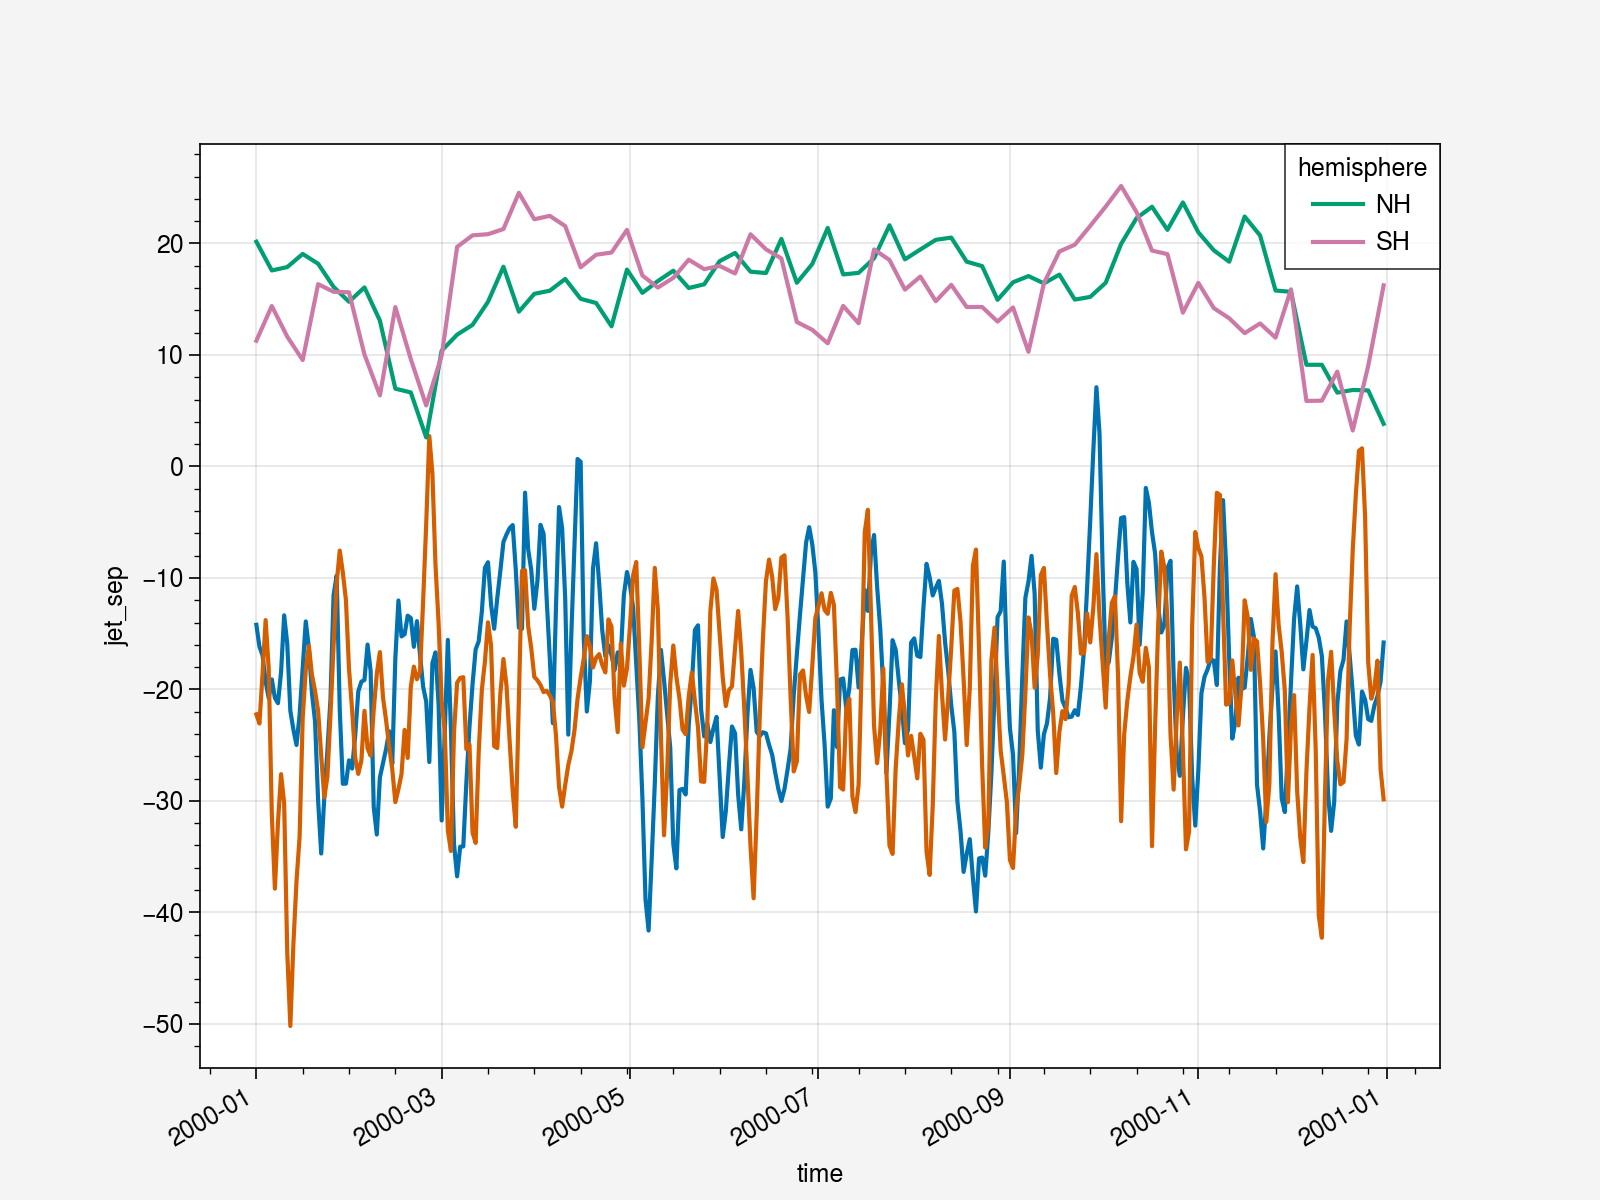

In [73]:
edj_ep_budget.plot.line(x='time')
ds_js.jet_sep.plot.line(x='time')